# Compute transition numbers for green, brown and neutral occupations
Felix Zaussinger | 15.06.2021

## Core Analysis Goal(s)
1. Map transition pathways for occupations likely affected by coal phase-outs by
using mining-related occupations as a proxy.

## Key Insight(s)
1.

In [1]:
import os
import sys
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("paper")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("ticks")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

Define directory structure

In [2]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "reports", "figures")

ESCO data set components

In [3]:
occ = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "occupations_en.csv"))
skill_groups = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "skillGroups_en.csv"))
skills = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "skills_en.csv"))
occ_skills_mapping = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "occupationSkillRelations.csv"))

In [4]:
df_metadata = pd.read_csv(
    os.path.join(data_interim, "ESCO_ONET_METADATA.csv"),
    index_col=0
)

df_metadata.greenness_vona_2018_v2 = df_metadata.greenness_vona_2018_v2.fillna(0)

# convert job zone to categorical var
#df_metadata.job_zone = pd.Categorical(df_metadata.job_zone, ordered=True)
df_metadata.isco_level_1 = pd.Categorical(df_metadata.isco_level_1, ordered=False)
df_metadata.isco_level_2 = pd.Categorical(df_metadata.isco_level_2, ordered=False)

In [5]:
# nesta report
sim_kanders = np.load(
    os.path.join(data_raw, "mcc_data", "processed", "sim_matrices", "OccupationSimilarity_Combined.npy")
)

np.fill_diagonal(sim_kanders, 0)

## Determine closest matches based on skill similiarity

In [6]:
# source: https://github.com/nestauk/mapping-career-causeways/blob/main/mapping_career_causeways/compare_nodes_utils.py
def find_closest(i, similarity_matrix, df):
    """
    Method for reporting the closest neighbours to a node i given a similarity matrix;
    useful during exploratory data analysis.
    Parameters
    ----------
    i (int OR None):
        Determines for which node where are assessing the closest neighbours;
        if i==None, a random node is chosen.
    similarity_matrix (numpy.ndarray):
        Similarity matrix determining the closeness between each pair of nodes.
    df (pandas.DataFrame):
        Dataframe to be used for reporting the closest neighbours; must have then
        same number of rows as the similarity matrix
    Returns
    -------
    df (pandas.DataFrame):
        The same input dataframe with an added column for similarity values
        between node i and the rest of the nodes, ordered in a descending order
        of similarity.
    """
    if type(i) == type(None):
        i = np.random.randint(similarity_matrix.shape[0])

    most_similar = np.flip(np.argsort(similarity_matrix[i,:]))
    similarity = np.flip(np.sort(similarity_matrix[i,:]))

    df = df.copy().loc[most_similar]
    df['similarity'] = similarity
    return df

## Identify mining-related occupations

In [7]:
# cue 1: in mining-related isco occupation
mining_occupations = [1322, 2146, 3117, 3121, 8111, 9311]
df_metadata["mining_isco"] = df_metadata.isco_level_4.isin(mining_occupations)

In [8]:
# cue 2: mining-related keywords in occupation description
mining_keywords = ["mine", "Mine", "mining", "Mining"]

mining_kw = []
for occ_desc in occ.description:
    mining_kw.append(any(True if kw in occ_desc.split(" ") else False for kw in mining_keywords))

df_metadata["mining_kw"] = mining_kw

# keyword cue yields 31 mining occs, isco cue yields 30
df_metadata.mining_isco.value_counts()
df_metadata.mining_kw.value_counts()

#df_metadata["is_mining"] = np.logical_or(df_metadata.mining_kw, df_metadata.mining_isco)

False    2911
True       31
Name: mining_kw, dtype: int64

In [9]:
# cue 3: petroleum, oil and gas
fossil_fuel_keywords = ["petroleum", "Petroleum", "oil", "Oil", "gas", "Gas"]

fossil_fuel_occs = []
for occ_desc in occ.description:
    fossil_fuel_occs.append(any(True if kw in occ_desc.split(" ") else False for kw in fossil_fuel_keywords))

In [10]:
occ["fossil_fuel"] = fossil_fuel_occs
occ["is_brown"] = np.logical_or(df_metadata.mining_kw, df_metadata.mining_isco)

occ_ff = occ.query("is_brown == True or fossil_fuel == True")
occ_ff.to_excel(
    os.path.join(data_interim, "occupations_mining_fossil_fuels.xlsx"),
    sheet_name="keyword_selection"
)

In [11]:
# classification after manual inspection
occ_ff_commented = pd.read_excel(
    os.path.join(data_interim, "occupations_mining_fossil_fuels_commented.xlsx"),
    sheet_name="keyword_selection"
)

occ_ff_commented = occ_ff_commented.rename(columns={'Unnamed: 0': "id"})
occ_ff_commented["selection_broad"] = occ_ff_commented["felix"]
occ_ff_commented["selection_narrow"] = (occ_ff_commented.felix == True) & (occ_ff_commented.comment != "unsure")

df_brown_occ_narrow = occ_ff_commented.query("selection_narrow == True")

# merge back to df_metadata
df_metadata = pd.merge(
    df_metadata,
    occ_ff_commented[["id", "selection_narrow"]],
    on="id",
    how="left"
).rename(
    columns={"selection_narrow": "is_brown"}
).fillna(
    value={"is_brown": False}
)

In [12]:
# before manual inspection & without ff keywords
df_mining_occ = df_metadata.query("is_brown == True")
df_mining_occ

,id,concept_uri,preferred_label,isco_level_4,onet_code,onet_occupation,isco_level_1,isco_level_2,isco_level_3,occupation_type,n_new_green_tasks,n_existing_green_tasks,n_non_green_tasks,greenness_vona_2018,greenness_vona_2018_v2,total_paid_hours,annual_earnings,employment_share,employment_count,job_zone,education_level,related_work_experience,on_the_job_training,skill_level_ilo,new_jobs_absorbing_ilo_2030_es,new_jobs_net_ilo_2030_es,jobs_lost_net_ilo_2030_es,jobs_lost_reallocated_ilo_2030_es,net_change_ilo_2030_es,new_jobs_absorbing_ilo_2030_ce,new_jobs_net_ilo_2030_ce,jobs_lost_net_ilo_2030_ce,jobs_lost_reallocated_ilo_2030_ce,net_change_ilo_2030_ce,mining_isco,mining_kw,is_brown
36,36,http://data.europa.eu/esco/occupation/026a5233...,petroleum pump system operator,3134,51-8093.00,"petroleum pump system operators, refinery oper...",3,31,313,Non Green,NaN,NaN,NaN,NaN,0.000000,38.709091,21750.916667,0.000072,2327.0,2.0,2.6289,5.3098,4.4393,H,748000.0,528000.0,206000.0,-748000.0,734000.0,3042000.0,1225000.0,-965000.0,-3042000.0,260000.0,False,False,True
82,82,http://data.europa.eu/esco/occupation/0633ec3f...,oil and gas production manager,1322,17-2151.00,"mining and geological engineers, including min...",1,13,132,Non Green,NaN,NaN,NaN,NaN,0.000000,39.344262,45669.058252,NaN,NaN,4.0,6.2073,7.7984,5.4027,H,136000.0,323000.0,-36000.0,-136000.0,287000.0,1095000.0,143000.0,-1110000.0,-1095000.0,-967000.0,True,False,True
405,405,http://data.europa.eu/esco/occupation/217e7ae2...,oil refinery control room operator,3134,51-8093.00,"petroleum pump system operators, refinery oper...",3,31,313,Non Green,NaN,NaN,NaN,NaN,0.000000,38.709091,21750.916667,0.000072,2327.0,2.0,2.6289,5.3098,4.4393,H,748000.0,528000.0,206000.0,-748000.0,734000.0,3042000.0,1225000.0,-965000.0,-3042000.0,260000.0,False,False,True
410,410,http://data.europa.eu/esco/occupation/21a42cfb...,gauger,8131,51-8093.00,"petroleum pump system operators, refinery oper...",8,81,813,Non Green,NaN,NaN,NaN,NaN,0.000000,39.965625,22211.820144,0.000053,1699.0,2.0,2.6289,5.3098,4.4393,M,339000.0,712000.0,-34000.0,-339000.0,678000.0,2913000.0,500.0,-5589000.0,-2913000.0,-5588500.0,False,False,True
429,429,http://data.europa.eu/esco/occupation/23993e79...,mine shift manager,3121,47-1011.00,first-line supervisors of construction trades ...,3,31,312,Non Green,NaN,NaN,NaN,NaN,0.000000,40.463750,24548.793651,NaN,NaN,3.0,2.8266,7.5779,6.2029,H,748000.0,528000.0,206000.0,-748000.0,734000.0,3042000.0,1225000.0,-965000.0,-3042000.0,260000.0,True,True,True
609,609,http://data.europa.eu/esco/occupation/32548f7e...,environmental mining engineer,2143,17-2081.00,environmental engineers,2,21,214,Green Enhanced Skills,3.0,25.0,0.0,1.000000,1.000000,40.796026,34463.526055,NaN,NaN,5.0,7.1481,5.5545,4.7029,H,500000.0,263000.0,253000.0,-500000.0,516000.0,1379000.0,1274000.0,-397000.0,-1379000.0,877000.0,False,True,True
769,769,http://data.europa.eu/esco/occupation/3f863faa...,drilling engineer,2146,17-2171.00,petroleum engineers,2,21,214,Non Green,NaN,NaN,NaN,NaN,0.000000,40.178069,36554.033333,0.000359,11552.0,4.0,6.1619,8.3178,4.9429,H,500000.0,263000.0,253000.0,-500000.0,516000.0,1379000.0,1274000.0,-397000.0,-1379000.0,877000.0,True,True,True
789,789,http://data.europa.eu/esco/occupation/425f4904...,underground heavy equipment operator,8111,47-5042.00,mine cutting and channeling machine operators,8,81,811,Non Green,NaN,NaN,NaN,NaN,0.000000,41.125041,28282.005769,0.000021,680.0,2.0,1.9195,4.8173,3.1056,M,339000.0,712000.0,-34000.0,-339000.0,678000.0,2913000.0,500.0,-5589000.0,-2913000.0,-5588500.0,True,True,True
846,846,http://data.europa.eu/esco/occupation/47dd863b...,liquid fuel engineer,2146,17-2171.00,petroleum engineers,2,21,214,Non Green,NaN,NaN,NaN,NaN,0.000000,40.178069,36554.033333,0.000359,11552.0,4.0,6.1619,8.3178,4.9429,H,500000.0,263000.0,253000.0,-500000.0,516000.0,1379000.0,1274000.0,-397000.0,-1379000.0,877000.0,True,False,True
876,876,http://data.europa.eu/esco/occupation/4a215d87...,su

## Iterate over all occupations and identify transition options

In [13]:
transition_numbers_all = {}
df_occ = pd.DataFrame(occ.conceptUri.values, columns=["conceptUri"])

# iterate over mining occupations
for i in tqdm(df_metadata.id):

    # find closest occupations
    sim_ranking = find_closest(
        i=i,
        similarity_matrix=sim_kanders,
        df=df_occ
    )

    # print source occupation
    source_occ = df_metadata.loc[i, :]
    # print("Source occupation: {}".format(source_occ.preferred_label))

    # merge metadata
    result = pd.merge(
        sim_ranking,
        df_metadata[[
            "concept_uri",
            "preferred_label",
            "greenness_vona_2018_v2",
            "annual_earnings",
            "is_brown",
            "job_zone"
        ]],
        left_on="conceptUri",
        right_on="concept_uri",
        how="left"
    ).drop(columns=["concept_uri"], axis=1)

    # add transitions metadata
    result["job_zone_delta"] = np.abs(source_occ.job_zone - result.job_zone)
    result["earnings_ratio"] = result.annual_earnings / source_occ.annual_earnings

    result["is_viable"] = (result.similarity >= 0.3) & (result.job_zone_delta <= 1)
    result["is_highly_viable"] = (result.similarity >= 0.4)  & (result.job_zone_delta <= 1)
    result["is_desirable"] = result.is_viable & (result.earnings_ratio >= 0.75)
    result["is_highly_desirable"] = result.is_highly_viable & (result.earnings_ratio >= 0.75)
    result["is_green"] = result.greenness_vona_2018_v2 > 0
    result["is_neutral"] = (result.greenness_vona_2018_v2 == 0) & (result.is_brown == False)

    # highly viable transitions
    result["is_highly_viable_brown"] = result.is_highly_viable & (result.is_brown == True)
    result["is_highly_viable_neutral"] = result.is_highly_viable & (result.is_neutral == True)
    result["is_highly_viable_green"] = result.is_highly_viable & (result.is_green == True)

    # desirable transitions
    result["is_desirable_brown"] = result.is_desirable & (result.is_brown == True)
    result["is_desirable_neutral"] = result.is_desirable & (result.is_neutral == True)
    result["is_desirable_green"] = result.is_desirable & (result.is_green == True)

    # highly desirable transitions
    result["is_highly_desirable_brown"] = result.is_highly_desirable & (result.is_brown == True)
    result["is_highly_desirable_neutral"] = result.is_highly_desirable & (result.is_neutral == True)
    result["is_highly_desirable_green"] = result.is_highly_desirable & (result.is_green == True)

    # subset to viable transitions
    result_subset = result[result.is_viable == True]

    # subset to boolean cols
    boolean_cols = [
        'is_viable', 'is_highly_viable', 'is_desirable', 'is_highly_desirable',
        'is_green', 'is_neutral', 'is_brown',
        'is_highly_viable_brown', 'is_highly_viable_neutral', 'is_highly_viable_green',
        'is_desirable_brown', 'is_desirable_neutral', 'is_desirable_green',
        'is_highly_desirable_brown', 'is_highly_desirable_neutral', 'is_highly_desirable_green'
    ]

    # subset to viable transitions only
    result_subset_bools = result_subset[boolean_cols]

    # count True's per boolean column
    s_sum = result_subset_bools.sum()

    transition_numbers_all[i] = s_sum

100%|██████████| 2942/2942 [01:02<00:00, 47.39it/s]


In [14]:
# to df
cols_merge = ["preferred_label", "isco_level_1"] #, "annual_earnings", "education_level", "related_work_experience", "on_the_job_training"]
df_transition_numbers_all = pd.DataFrame.from_dict(transition_numbers_all).transpose()
df_transition_numbers_all_labelled = pd.concat(
    [df_transition_numbers_all, df_metadata[cols_merge]], axis=1
)

In [15]:
# rename binary identifier column to avoid confusion with transition number col
df_metadata = df_metadata.rename(columns={"is_brown": "brown"})

# delineate "neutral" occupations as those that are non-green and non-mining
df_metadata["neutral"] = (df_metadata.greenness_vona_2018_v2 == 0) & (df_metadata.brown == False)

# bool for green occupations
df_metadata["green"] = (df_metadata.greenness_vona_2018_v2 > 0)

In [16]:
# merge transition numbers to all the other metadata, export csv
df_metadata_transitions = pd.concat(
    [df_metadata, df_transition_numbers_all], axis=1
)

df_metadata_transitions.to_csv(
    os.path.join(data_interim, "esco_onet_metadata_transition_numbers.csv")
)

## Visualise transition numbers for all occupations

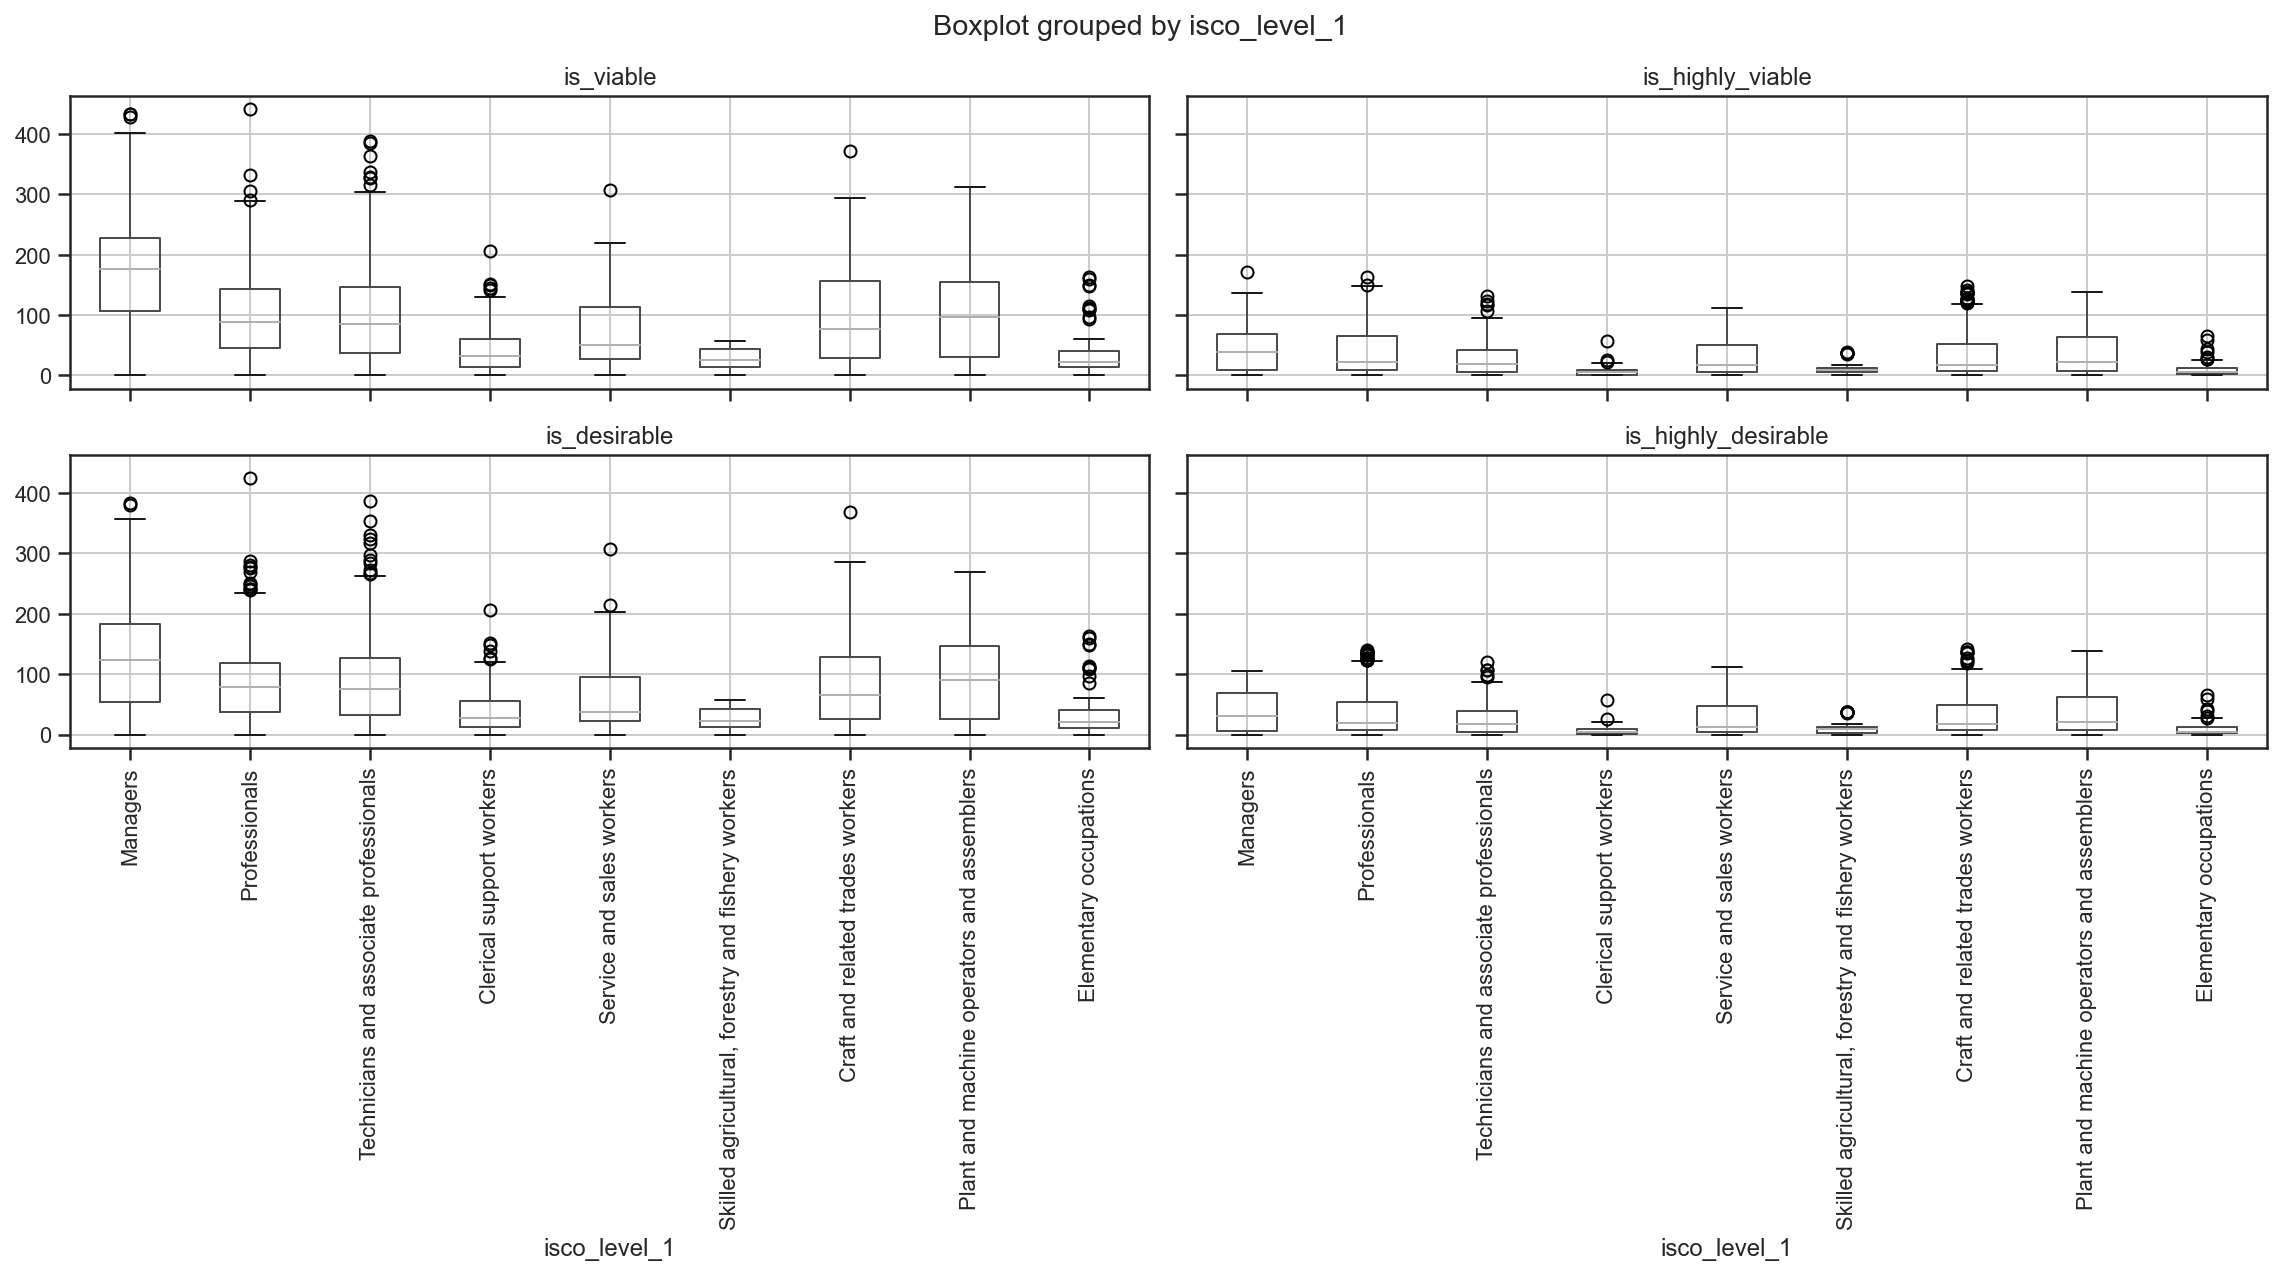

In [17]:
# boxplots of transition numbers by isco lvl 1 groups
isco_lvl1_mapping = {
    1: "Managers",
    2: "Professionals",
    3: "Technicians and associate professionals",
    4: "Clerical support workers",
    5: "Service and sales workers",
    6: "Skilled agricultural, forestry and fishery workers",
    7: "Craft and related trades workers",
    8: "Plant and machine operators and assemblers",
    9: "Elementary occupations"
}

df_transition_numbers_all_labelled.boxplot(
    column=["is_viable", "is_highly_viable", "is_desirable", "is_highly_desirable"],
    by="isco_level_1",
    layout=(2,2),
    rot=90
)

plt.xticks(np.arange(1,10), list(isco_lvl1_mapping.values()))

plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "n_transitions_all_occ_isco_lvl1.png"),
    dpi=150,
    bbox_inches="tight"
)

In [18]:
df_transition_numbers_all_labelled

,is_viable,is_highly_viable,is_desirable,is_highly_desirable,is_green,is_neutral,is_brown,is_highly_viable_brown,is_highly_viable_neutral,is_highly_viable_green,is_desirable_brown,is_desirable_neutral,is_desirable_green,is_highly_desirable_brown,is_highly_desirable_neutral,is_highly_desirable_green,preferred_label,isco_level_1
0,19,0,18,0,2,17,0,0,0,0,0,16,2,0,0,0,technical director,2
1,174,123,174,123,11,163,0,0,119,4,0,163,11,0,119,4,metal drawing machine operator,8
2,250,60,249,60,41,207,2,0,34,26,2,207,40,0,34,26,precision device inspector,7
3,62,2,57,2,10,52,0,0,2,0,0,50,7,0,2,0,air traffic safety technician,3
4,217,13,200,12,72,144,1,0,11,2,1,131,68,0,10,2,hospitality revenue manager,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,79,36,72,33,24,55,0,0,27,9,0,51,21,0,26,7,demographer,2
2938,10,3,9,3,5,5,0,0,0,3,0,4,5,0,0,3,sorter labourer,9
2939,36,16,32,16,1,35,0,0,16,0,0,31,1,0,16,0,armoured car guard,5
2940,44,3,23,2,5,39,0,0,3,0,0,18,5,0,2,0,civil service administrative officer,2


In [19]:
# Visualise differences in transition options to neutral, green and mining
# occupations

value_vars = list(filter(None, [col_label if "is_" in col_label else None for col_label in df_transition_numbers_all_labelled.columns]))
df_ntrans_long = df_transition_numbers_all_labelled.melt(value_vars=value_vars, id_vars=['preferred_label', 'isco_level_1'])

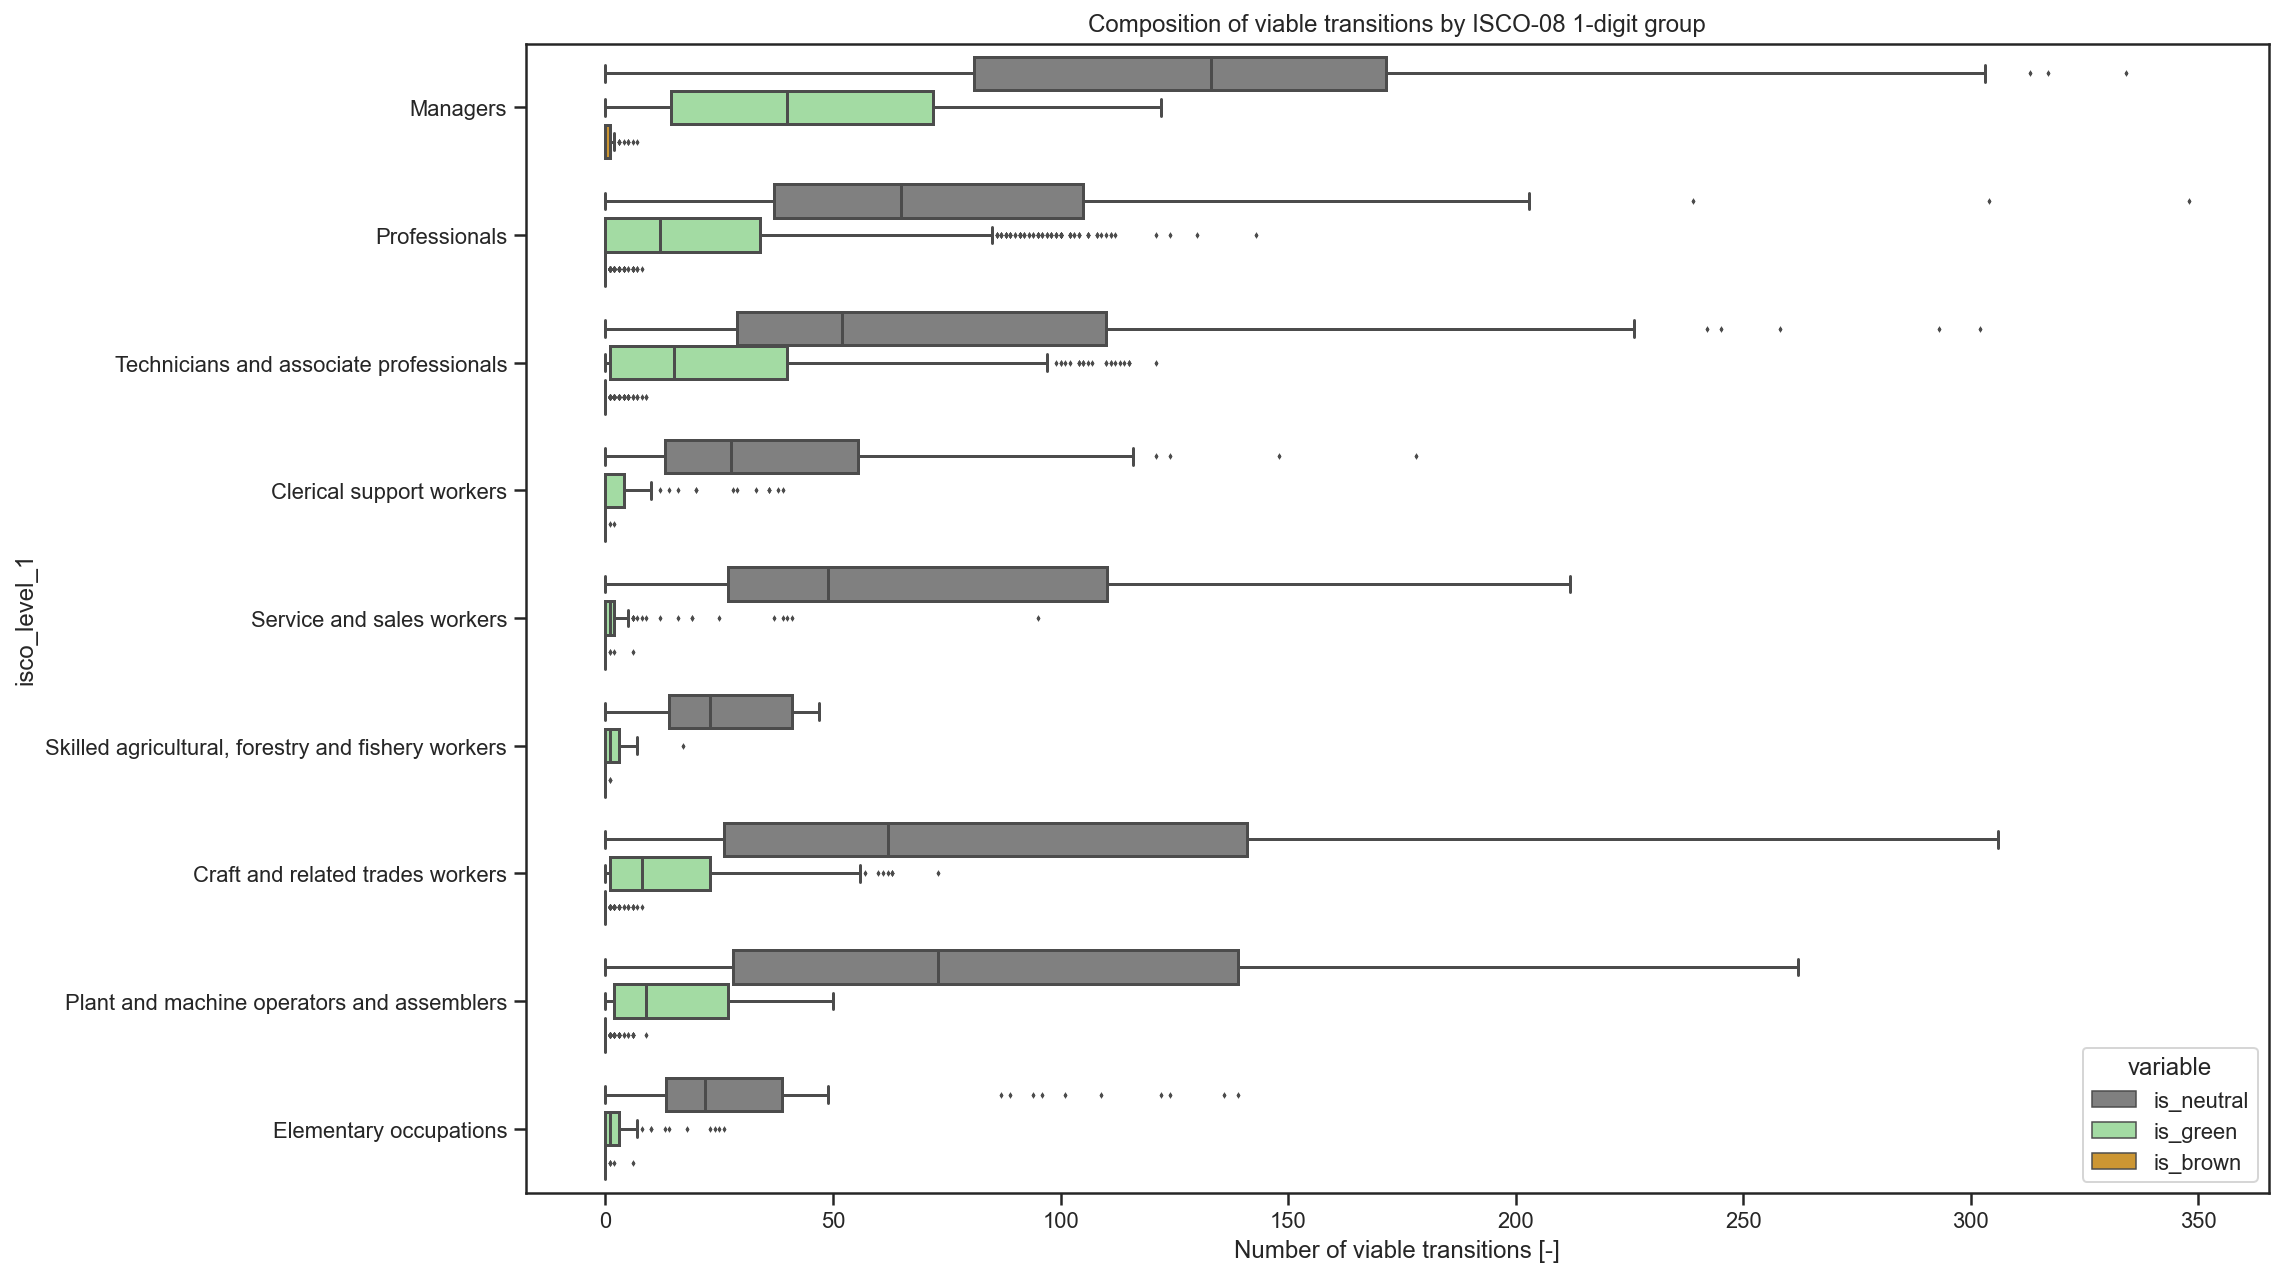

In [20]:
# viable
df_ntrans_long_is_viable = df_ntrans_long.query("variable == 'is_brown' or variable == 'is_neutral' or variable == 'is_green'")

ax = sns.boxplot(
    y="isco_level_1",
    x="value",
    hue="variable",
    hue_order=["is_neutral", "is_green", "is_brown"],
    palette=["grey", "lightgreen", "orange"],
    saturation=0.6,
    fliersize=1,
    orient="h",
    data=df_ntrans_long_is_viable
)

ax.set_title("Composition of viable transitions by ISCO-08 1-digit group")
ax.set_xlabel("Number of viable transitions [-]")
plt.yticks(np.arange(0,9), list(isco_lvl1_mapping.values()), rotation='horizontal')
plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "n_transitions_all_occ_viable_composition_isco_lvl1.png"),
    dpi=150,
    bbox_inches="tight"
)

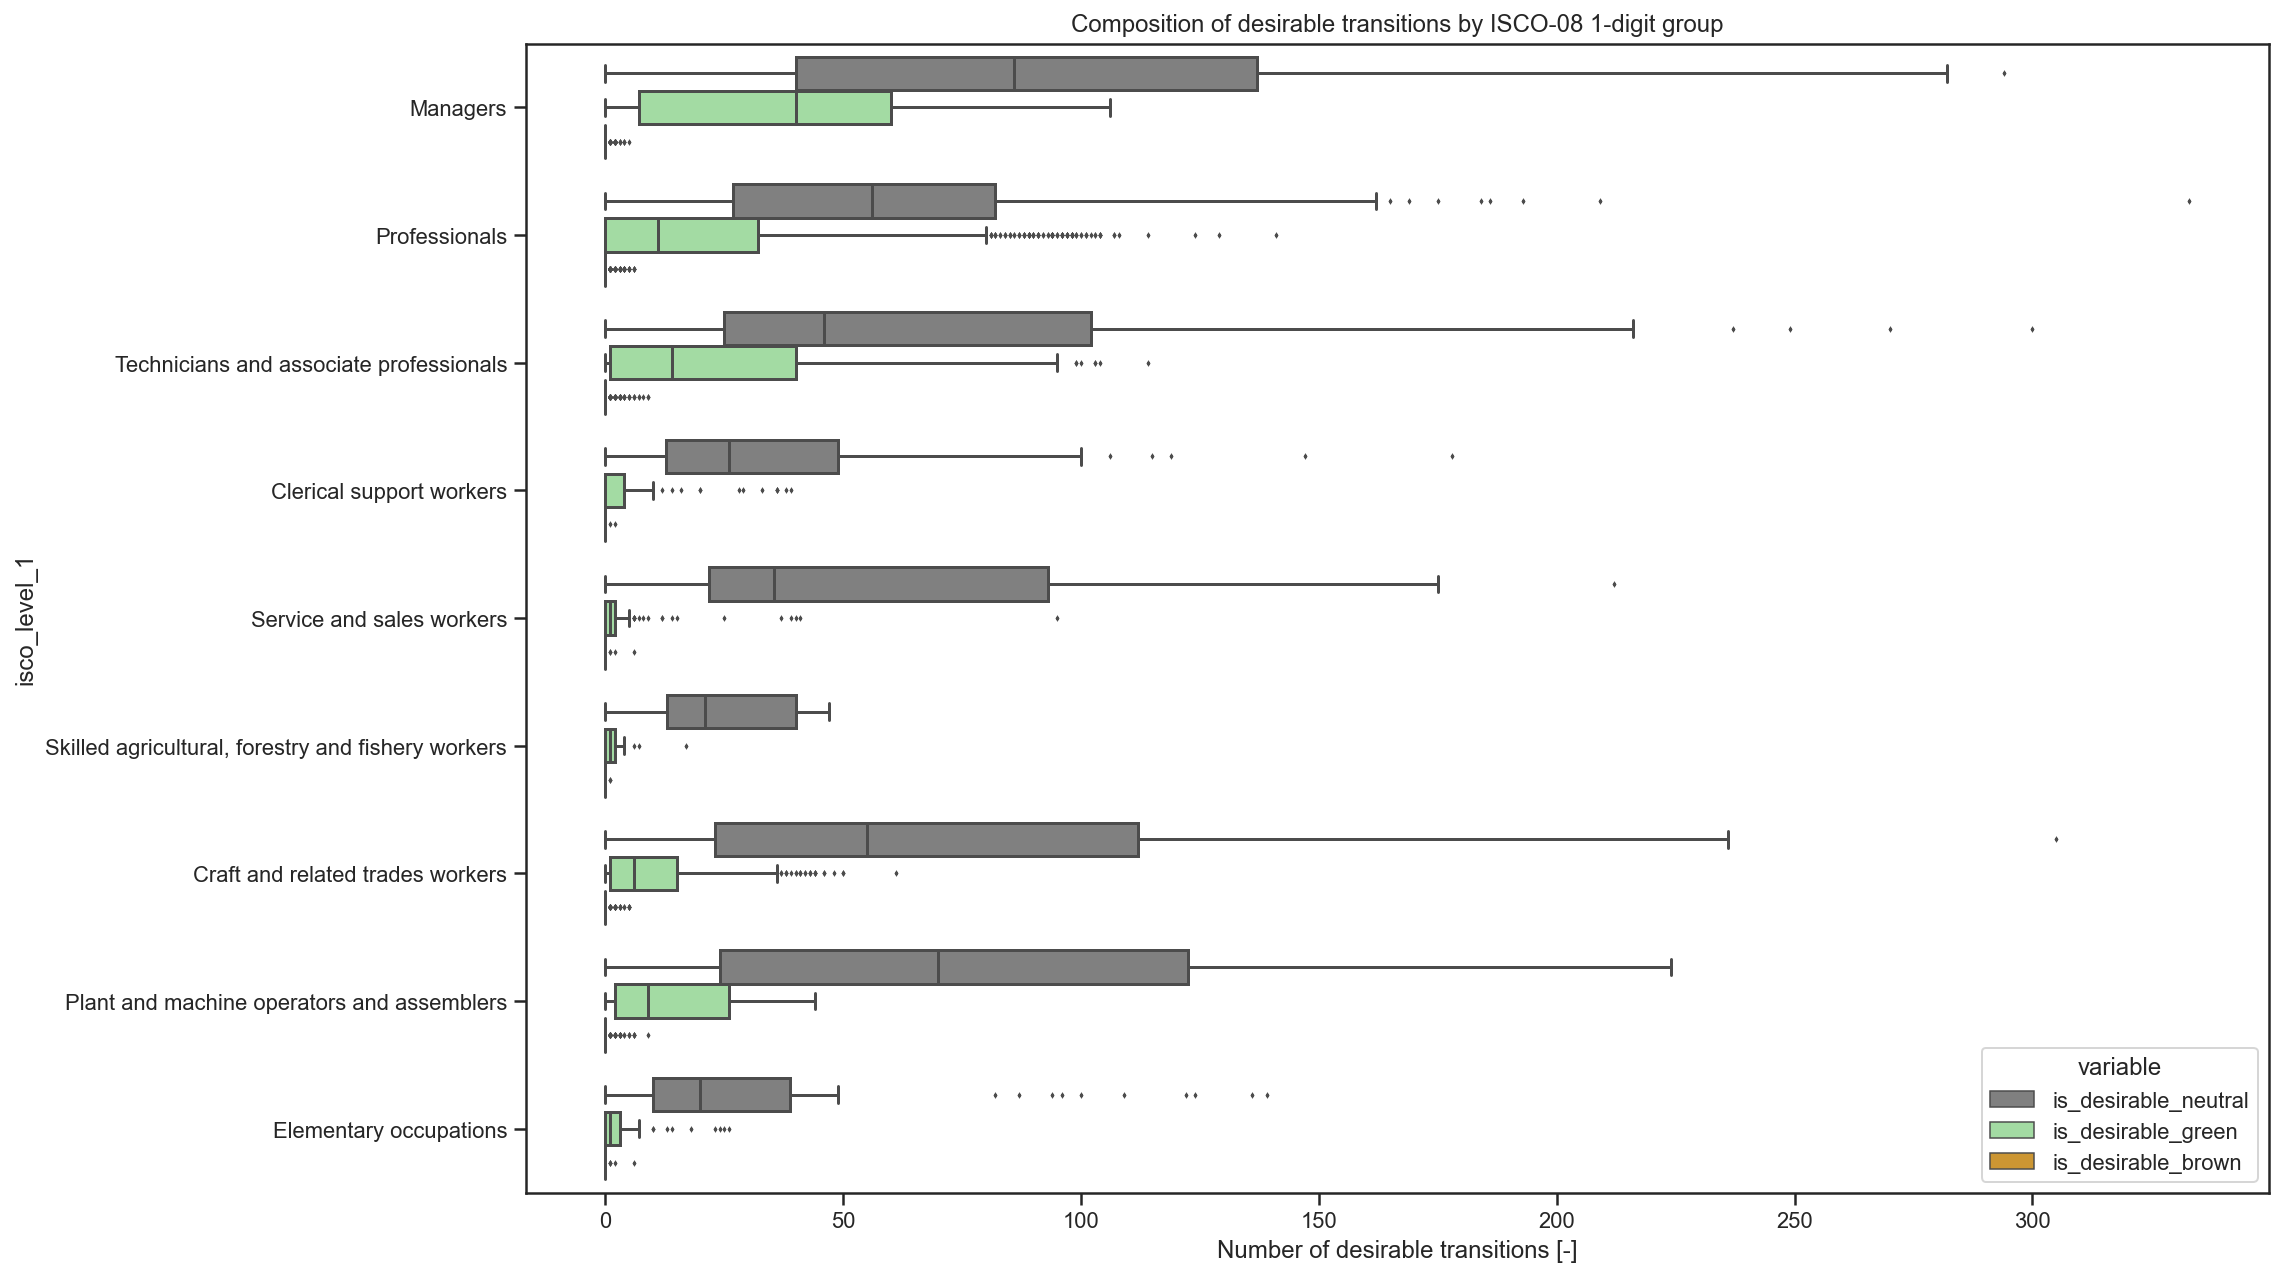

In [21]:
# desirable
df_ntrans_long_is_desirable = df_ntrans_long.query("variable == 'is_desirable_brown' or variable == 'is_desirable_neutral' or variable == 'is_desirable_green'")

ax = sns.boxplot(
    y="isco_level_1",
    x="value",
    hue="variable",
    hue_order=["is_desirable_neutral", "is_desirable_green", "is_desirable_brown"],
    palette=["grey", "lightgreen", "orange"],
    saturation=0.6,
    fliersize=1,
    orient="h",
    data=df_ntrans_long_is_desirable
)

ax.set_title("Composition of desirable transitions by ISCO-08 1-digit group")
ax.set_xlabel("Number of desirable transitions [-]")
plt.yticks(np.arange(0,9), list(isco_lvl1_mapping.values()), rotation='horizontal')
plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "n_transitions_all_occ_desirable_composition_isco_lvl1.png"),
    dpi=150,
    bbox_inches="tight"
)

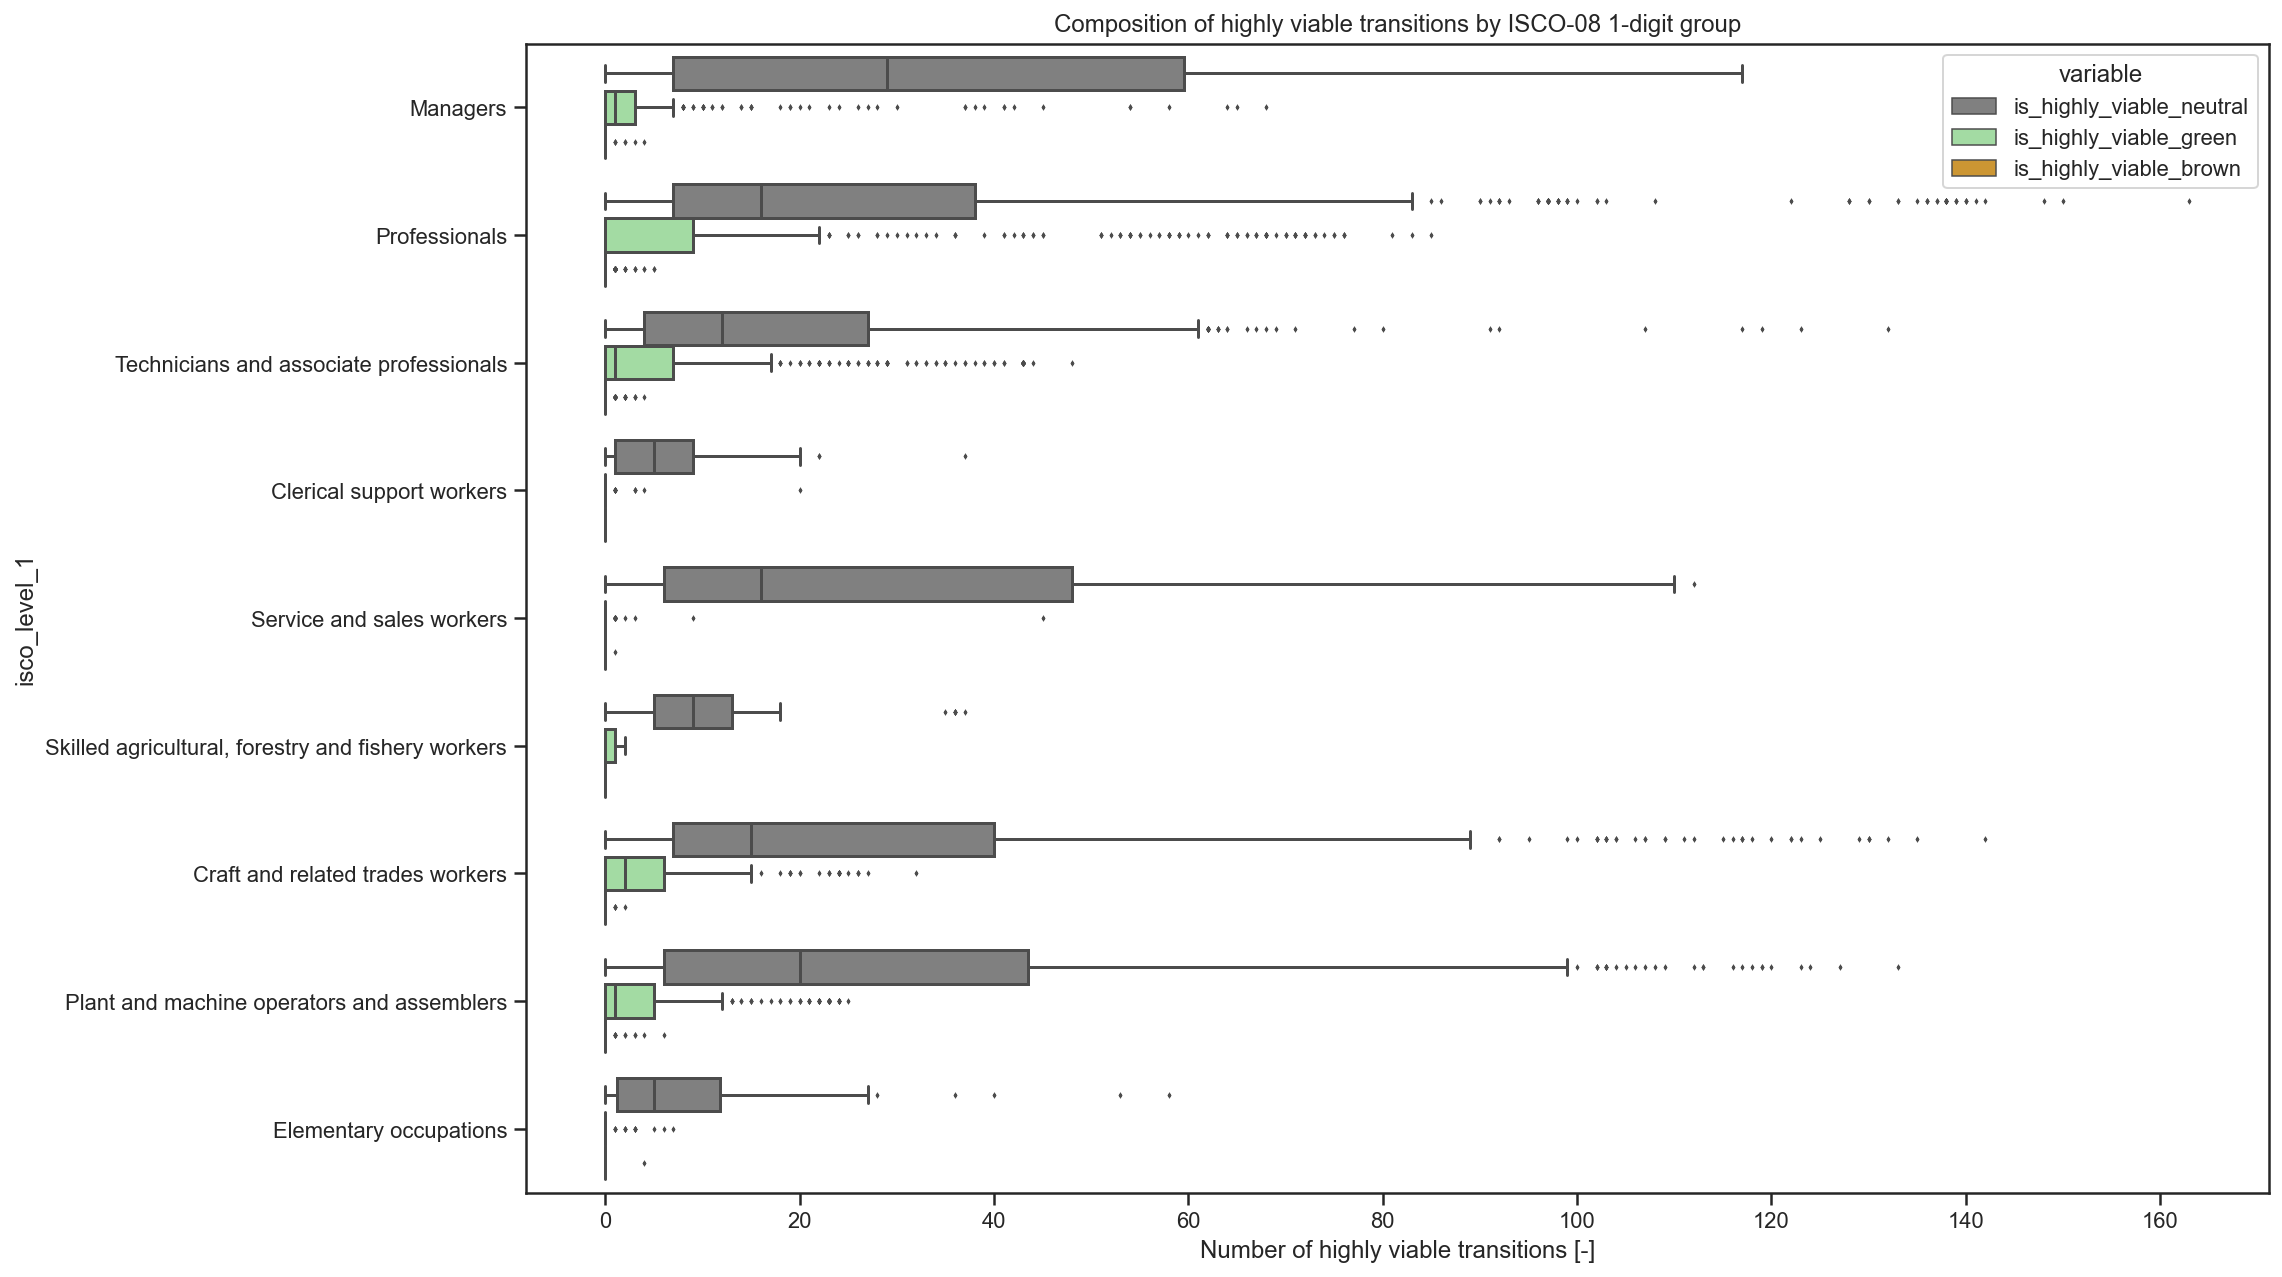

In [22]:
# highly viable
df_ntrans_long_is_highly_viable = df_ntrans_long.query("variable == 'is_highly_viable_brown' or variable == 'is_highly_viable_neutral' or variable == 'is_highly_viable_green'")

ax = sns.boxplot(
    y="isco_level_1",
    x="value",
    hue="variable",
    hue_order=["is_highly_viable_neutral", "is_highly_viable_green", "is_highly_viable_brown"],
    palette=["grey", "lightgreen", "orange"],
    saturation=0.6,
    fliersize=1,
    orient="h",
    data=df_ntrans_long_is_highly_viable
)

ax.set_title("Composition of highly viable transitions by ISCO-08 1-digit group")
ax.set_xlabel("Number of highly viable transitions [-]")
plt.yticks(np.arange(0,9), list(isco_lvl1_mapping.values()), rotation='horizontal')
plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "n_transitions_all_occ_highly_viable_composition_isco_lvl1.png"),
    dpi=150,
    bbox_inches="tight"
)

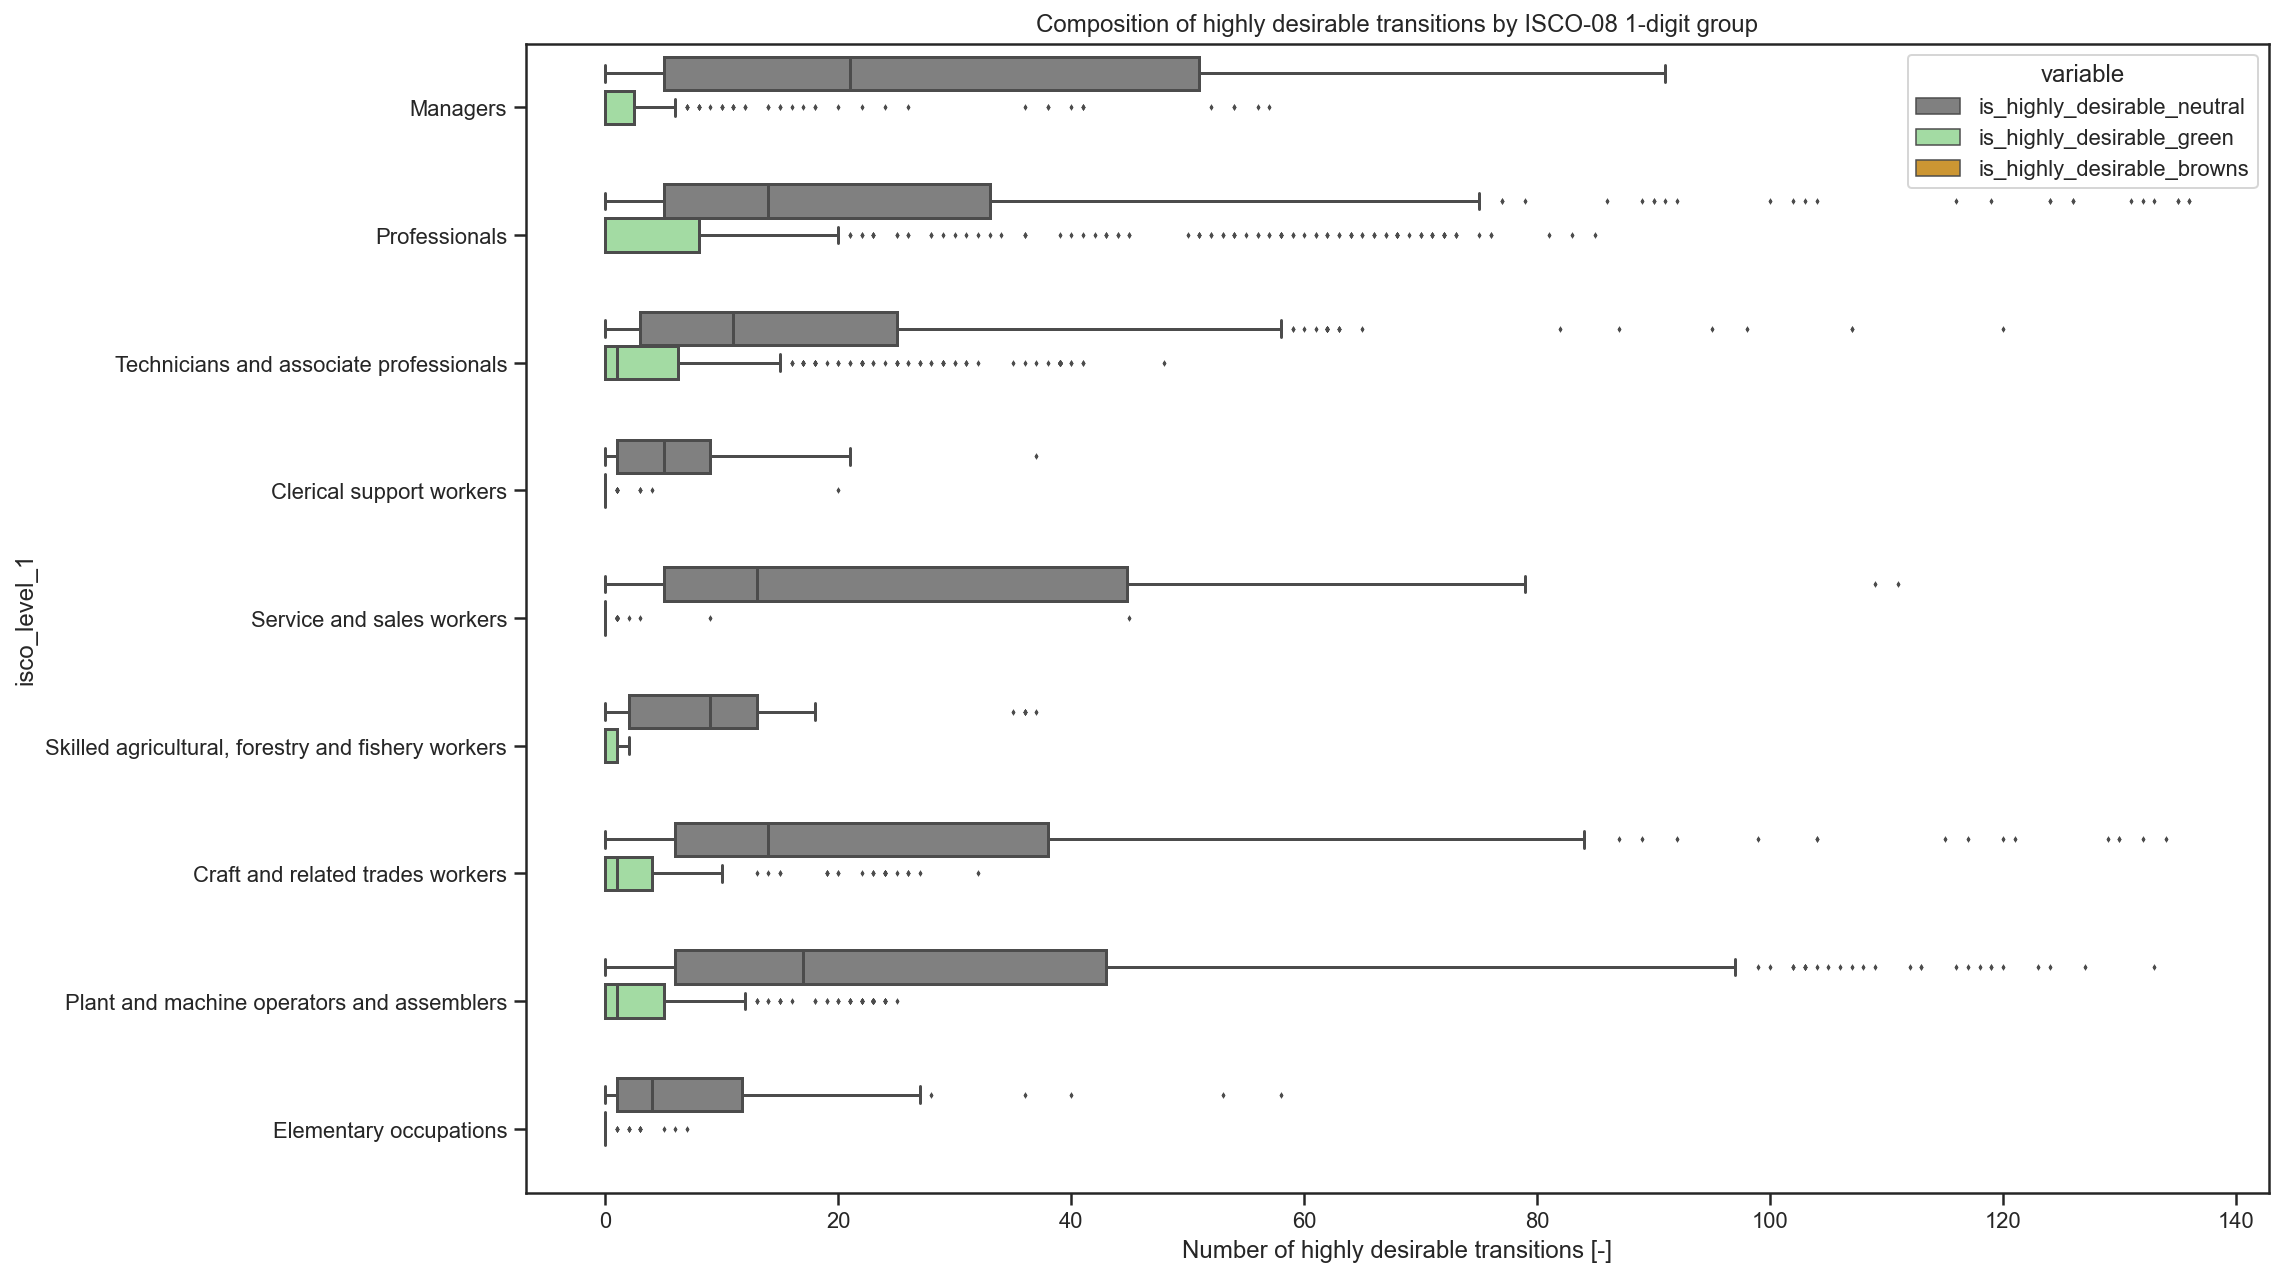

In [23]:
df_ntrans_long_is_highly_desirable = df_ntrans_long.query("variable == 'is_highly_desirable_brown' or variable == 'is_highly_desirable_neutral' or variable == 'is_highly_desirable_green'")

ax = sns.boxplot(
    y="isco_level_1",
    x="value",
    hue="variable",
    hue_order=["is_highly_desirable_neutral", "is_highly_desirable_green", "is_highly_desirable_browns"],
    palette=["grey", "lightgreen", "orange"],
    saturation=0.6,
    fliersize=1,
    orient="h",
    data=df_ntrans_long_is_highly_desirable
)

ax.set_title("Composition of highly desirable transitions by ISCO-08 1-digit group")
ax.set_xlabel("Number of highly desirable transitions [-]")
plt.yticks(np.arange(0,9), list(isco_lvl1_mapping.values()), rotation='horizontal')
plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "n_transitions_all_occ_highly_desirable_composition_isco_lvl1.png"),
    dpi=150,
    bbox_inches="tight"
)

## Regression analysis of transition numbers

In [24]:
# to df
cols_merge = ["preferred_label", "isco_level_1", "annual_earnings", "education_level", "related_work_experience", "on_the_job_training", "job_zone"]
# df_transition_numbers_all = pd.DataFrame.from_dict(transition_numbers_all).transpose()
df_transition_numbers_all_labelled_wide = pd.concat(
    [df_transition_numbers_all, df_metadata[cols_merge]], axis=1
)

df_transition_numbers_all_labelled_wide

,is_viable,is_highly_viable,is_desirable,is_highly_desirable,is_green,is_neutral,is_brown,is_highly_viable_brown,is_highly_viable_neutral,is_highly_viable_green,is_desirable_brown,is_desirable_neutral,is_desirable_green,is_highly_desirable_brown,is_highly_desirable_neutral,is_highly_desirable_green,preferred_label,isco_level_1,annual_earnings,education_level,related_work_experience,on_the_job_training,job_zone
0,19,0,18,0,2,17,0,0,0,0,0,16,2,0,0,0,technical director,2,37555.308176,6.2477,8.0309,4.3843,4.0
1,174,123,174,123,11,163,0,0,119,4,0,163,11,0,119,4,metal drawing machine operator,8,22031.963636,2.1163,2.4383,3.6486,2.0
2,250,60,249,60,41,207,2,0,34,26,2,207,40,0,34,26,precision device inspector,7,22430.367647,2.5397,4.8863,4.0288,2.0
3,62,2,57,2,10,52,0,0,2,0,0,50,7,0,2,0,air traffic safety technician,3,32754.000000,4.3848,5.4808,4.0782,3.0
4,217,13,200,12,72,144,1,0,11,2,1,131,68,0,10,2,hospitality revenue manager,2,38839.816377,6.8261,6.3481,3.8265,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,79,36,72,33,24,55,0,0,27,9,0,51,21,0,26,7,demographer,2,36135.290249,8.3000,5.5000,4.6000,5.0
2938,10,3,9,3,5,5,0,0,0,3,0,4,5,0,0,3,sorter labourer,9,21357.054545,3.1532,3.3559,2.8314,2.0
2939,36,16,32,16,1,35,0,0,16,0,0,31,1,0,16,0,armoured car guard,5,24315.540984,2.2215,3.2642,2.0230,2.0
2940,44,3,23,2,5,39,0,0,3,0,0,18,5,0,2,0,civil service administrative officer,2,33292.986333,3.9636,6.9711,3.4248,3.0


In [25]:
from stargazer.stargazer import Stargazer

df_transition_numbers_all_labelled_wide["is_green_ratio"] = \
    df_transition_numbers_all_labelled_wide["is_green"] / df_transition_numbers_all_labelled_wide["is_viable"]

reg_greenness = ols(
    formula="is_green_ratio ~ annual_earnings + education_level + related_work_experience + on_the_job_training + job_zone + C(isco_level_1)",
    data=df_transition_numbers_all_labelled_wide
).fit(cov_type='HC3')

Stargazer([reg_greenness])

## Iterate over mining occupations and identify transition options

In [26]:
df_brown_occ_narrow
df_metadata

,id,concept_uri,preferred_label,isco_level_4,onet_code,onet_occupation,isco_level_1,isco_level_2,isco_level_3,occupation_type,n_new_green_tasks,n_existing_green_tasks,n_non_green_tasks,greenness_vona_2018,greenness_vona_2018_v2,total_paid_hours,annual_earnings,employment_share,employment_count,job_zone,education_level,related_work_experience,on_the_job_training,skill_level_ilo,new_jobs_absorbing_ilo_2030_es,new_jobs_net_ilo_2030_es,jobs_lost_net_ilo_2030_es,jobs_lost_reallocated_ilo_2030_es,net_change_ilo_2030_es,new_jobs_absorbing_ilo_2030_ce,new_jobs_net_ilo_2030_ce,jobs_lost_net_ilo_2030_ce,jobs_lost_reallocated_ilo_2030_ce,net_change_ilo_2030_ce,mining_isco,mining_kw,brown,neutral,green
0,0,http://data.europa.eu/esco/occupation/00030d09...,technical director,2166,27-1011.00,art directors,2,21,216,Non Green,NaN,NaN,NaN,NaN,0.0000,36.670202,37555.308176,NaN,NaN,4.0,6.2477,8.0309,4.3843,H,500000.0,263000.0,253000.0,-500000.0,516000.0,1379000.0,1274000.0,-397000.0,-1379000.0,877000.0,False,False,False,True,False
1,1,http://data.europa.eu/esco/occupation/000e93a3...,metal drawing machine operator,8121,51-4021.00,"extruding and drawing machine setters, operato...",8,81,812,Non Green,NaN,NaN,NaN,NaN,0.0000,39.904110,22031.963636,0.000020,645.0,2.0,2.1163,2.4383,3.6486,M,339000.0,712000.0,-34000.0,-339000.0,678000.0,2913000.0,500.0,-5589000.0,-2913000.0,-5588500.0,False,False,False,True,False
2,2,http://data.europa.eu/esco/occupation/0019b951...,precision device inspector,7543,51-9061.00,"inspectors, testers, sorters, samplers, and we...",7,75,754,Green Enhanced Skills,2.0,0.0,30.0,0.066667,0.0625,38.709386,22430.367647,NaN,NaN,2.0,2.5397,4.8863,4.0288,M,48000.0,316000.0,500.0,-48000.0,316500.0,1315000.0,408000.0,-440000.0,-1315000.0,-32000.0,False,False,False,False,True
3,3,http://data.europa.eu/esco/occupation/0022f466...,air traffic safety technician,3155,17-3023.01,electronics engineering technicians,3,31,315,Non Green,NaN,NaN,NaN,NaN,0.0000,42.036716,32754.000000,0.000087,2797.0,3.0,4.3848,5.4808,4.0782,H,748000.0,528000.0,206000.0,-748000.0,734000.0,3042000.0,1225000.0,-965000.0,-3042000.0,260000.0,False,False,False,True,False
4,4,http://data.europa.eu/esco/occupation/002da35b...,hospitality revenue manager,2431,13-1161.00,market research analysts and marketing special...,2,24,243,Non Green,NaN,NaN,NaN,NaN,0.0000,36.354676,38839.816377,0.000648,20834.0,4.0,6.8261,6.3481,3.8265,H,218000.0,147000.0,-75000.0,-218000.0,72000.0,823000.0,837000.0,-53000.0,-823000.0,784000.0,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,2937,http://data.europa.eu/esco/occupation/ff656b3a...,demographer,2120,15-2041.00,statisticians,2,21,212,Non Green,NaN,NaN,NaN,NaN,0.0000,35.494487,36135.290249,0.000286,9184.0,5.0,8.3000,5.5000,4.6000,H,500000.0,263000.0,253000.0,-500000.0,516000.0,1379000.0,1274000.0,-397000.0,-1379000.0,877000.0,False,False,False,True,False
2938,2938,http://data.europa.eu/esco/occupation/ff8d4065...,sorter labourer,9612,51-9199.01,recycling and reclamation workers,9,96,961,New Green N&E,18.0,0.0,0.0,1.000000,1.0000,39.443972,21357.054545,0.000417,13414.0,2.0,3.1532,3.3559,2.8314,L,153000.0,305000.0,-17000.0,-153000.0,288000.0,860000.0,1152000.0,-111000.0,-860000.0,1041000.0,False,False,False,False,True
2939,2939,http://data.europa.eu/esco/occupation/ffa4dd5d...,armoured car guard,5414,33-9032.00,security guards,5,54,541,Non Green,NaN,NaN,NaN,NaN,0.0000,37.021429,24315.540984,NaN,NaN,2.0,2.2215,3.2642,2.0230,M,141000.0,179000.0,-27000.0,-141000.0,152000.0,744000.0,579000.0,-497000.0,-744000.0,82000.0,False,False,False,True,False
2940,2940,http://data.europa.eu/esco/occupation/ffade2f4...,civil service administrative officer,2422,11-3011.00,administrative services managers,2,24,242,Non Green,NaN,NaN,NaN,NaN,0.0000,35.240566,33292.986333,0.001128,36261.0,3.0,3.9636,6.9711,3.4248,H,21800

In [27]:
transition_numbers = {}
df_occ = pd.DataFrame(occ.conceptUri.values, columns=["conceptUri"])

# iterate over mining occupations
for i in df_brown_occ_narrow.id:

    # find closest occupations
    sim_ranking = find_closest(
        i=i,
        similarity_matrix=sim_kanders,
        df=df_occ
    )

    # print source occupation
    source_occ = df_metadata.loc[i, :]
    print("Source occupation: {}".format(source_occ.preferred_label))

    # merge metadata
    result = pd.merge(
        sim_ranking,
        df_metadata[[
            "concept_uri",
            "preferred_label",
            "greenness_vona_2018_v2",
            "annual_earnings",
            "brown",
            "job_zone"
        ]],
        left_on="conceptUri",
        right_on="concept_uri",
        how="left"
    ).drop(columns=["concept_uri"], axis=1)

    # add transitions metadata
    result["job_zone_delta"] = np.abs(source_occ.job_zone - result.job_zone)
    result["earnings_ratio"] = result.annual_earnings / source_occ.annual_earnings

    result["is_viable"] = (result.similarity >= 0.3) & (result.job_zone_delta <= 1)
    result["is_highly_viable"] = (result.similarity >= 0.4)  & (result.job_zone_delta <= 1)
    result["is_desirable"] = result.is_viable & (result.earnings_ratio >= 0.75)
    result["is_highly_desirable"] = result.is_highly_viable & (result.earnings_ratio >= 0.75)
    result["is_green"] = result.greenness_vona_2018_v2 > 0
    result["is_neutral"] = (result.greenness_vona_2018_v2 == 0) & (result.brown == False)

    # highly viable transitions
    result["is_highly_viable_brown"] = result.is_highly_viable & (result.brown == True)
    result["is_highly_viable_neutral"] = result.is_highly_viable & (result.is_neutral == True)
    result["is_highly_viable_green"] = result.is_highly_viable & (result.is_green == True)

    # desirable transitions
    result["is_desirable_brown"] = result.is_desirable & (result.brown == True)
    result["is_desirable_neutral"] = result.is_desirable & (result.is_neutral == True)
    result["is_desirable_green"] = result.is_desirable & (result.is_green == True)

    # highly desirable transitions
    result["is_highly_desirable_brown"] = result.is_highly_desirable & (result.brown == True)
    result["is_highly_desirable_neutral"] = result.is_highly_desirable & (result.is_neutral == True)
    result["is_highly_desirable_green"] = result.is_highly_desirable & (result.is_green == True)

    # subset to viable transitions
    result_subset = result[result.is_viable == True]

    # subset to boolean cols
    boolean_cols = [
        'is_viable', 'is_highly_viable', 'is_desirable', 'is_highly_desirable',
        'is_green', 'is_neutral', 'brown',
        'is_highly_viable_brown', 'is_highly_viable_neutral', 'is_highly_viable_green',
        'is_desirable_brown', 'is_desirable_neutral', 'is_desirable_green',
        'is_highly_desirable_brown', 'is_highly_desirable_neutral', 'is_highly_desirable_green'
    ]

    # subset to viable transitions only
    result_subset_bools = result_subset[boolean_cols]

    # count True's per boolean column
    s_sum = result_subset_bools.sum()

    transition_numbers[i] = s_sum

# to df
df_transition_numbers = pd.DataFrame.from_dict(transition_numbers).transpose()
df_transition_numbers = df_transition_numbers.reset_index().rename(columns={"index": "id"})
df_transition_numbers_labelled = pd.concat(
    [df_transition_numbers, df_brown_occ_narrow[["preferredLabel"]].reset_index(drop=True)],
    axis=1
)

Source occupation: petroleum pump system operator
Source occupation: oil and gas production manager
Source occupation: oil refinery control room operator
Source occupation: gauger
Source occupation: mine shift manager
Source occupation: environmental mining engineer
Source occupation: drilling engineer
Source occupation: underground heavy equipment operator
Source occupation: liquid fuel engineer
Source occupation: surface miner
Source occupation: underground miner
Source occupation: mine supervisor
Source occupation: tool pusher
Source occupation: petroleum engineer
Source occupation: refinery shift manager
Source occupation: roustabout
Source occupation: mining equipment mechanic
Source occupation: oil rig motorhand


In [28]:
df_transition_numbers_labelled

,id,is_viable,is_highly_viable,is_desirable,is_highly_desirable,is_green,is_neutral,brown,is_highly_viable_brown,is_highly_viable_neutral,is_highly_viable_green,is_desirable_brown,is_desirable_neutral,is_desirable_green,is_highly_desirable_brown,is_highly_desirable_neutral,is_highly_desirable_green,preferredLabel
0,36,50,9,50,9,12,32,6,3,4,2,6,32,12,3,4,2,petroleum pump system operator
1,82,122,21,80,16,37,81,5,2,12,8,4,50,27,1,10,6,oil and gas production manager
2,405,29,5,29,5,6,18,5,2,2,1,5,18,6,2,2,1,oil refinery control room operator
3,410,23,2,23,2,5,16,2,1,0,1,2,16,5,1,0,1,gauger
4,429,85,24,85,24,10,67,8,4,17,3,8,67,10,4,17,3,mine shift manager
5,609,170,84,166,83,102,64,4,2,23,59,4,63,99,2,23,58,environmental mining engineer
6,769,64,12,57,12,34,26,5,3,3,7,4,25,29,3,3,7,drilling engineer
7,789,20,6,20,6,1,13,6,3,3,0,6,13,1,3,3,0,underground heavy equipment operator
8,846,88,7,82,6,26,59,4,2,1,4,4,57,22,2,1,3,liquid fuel engineer
9,876,16,4,16,4,2,11,3,2,2,0,3,11,2,2,2,0,surface miner


## Visualise transition numbers for different categories

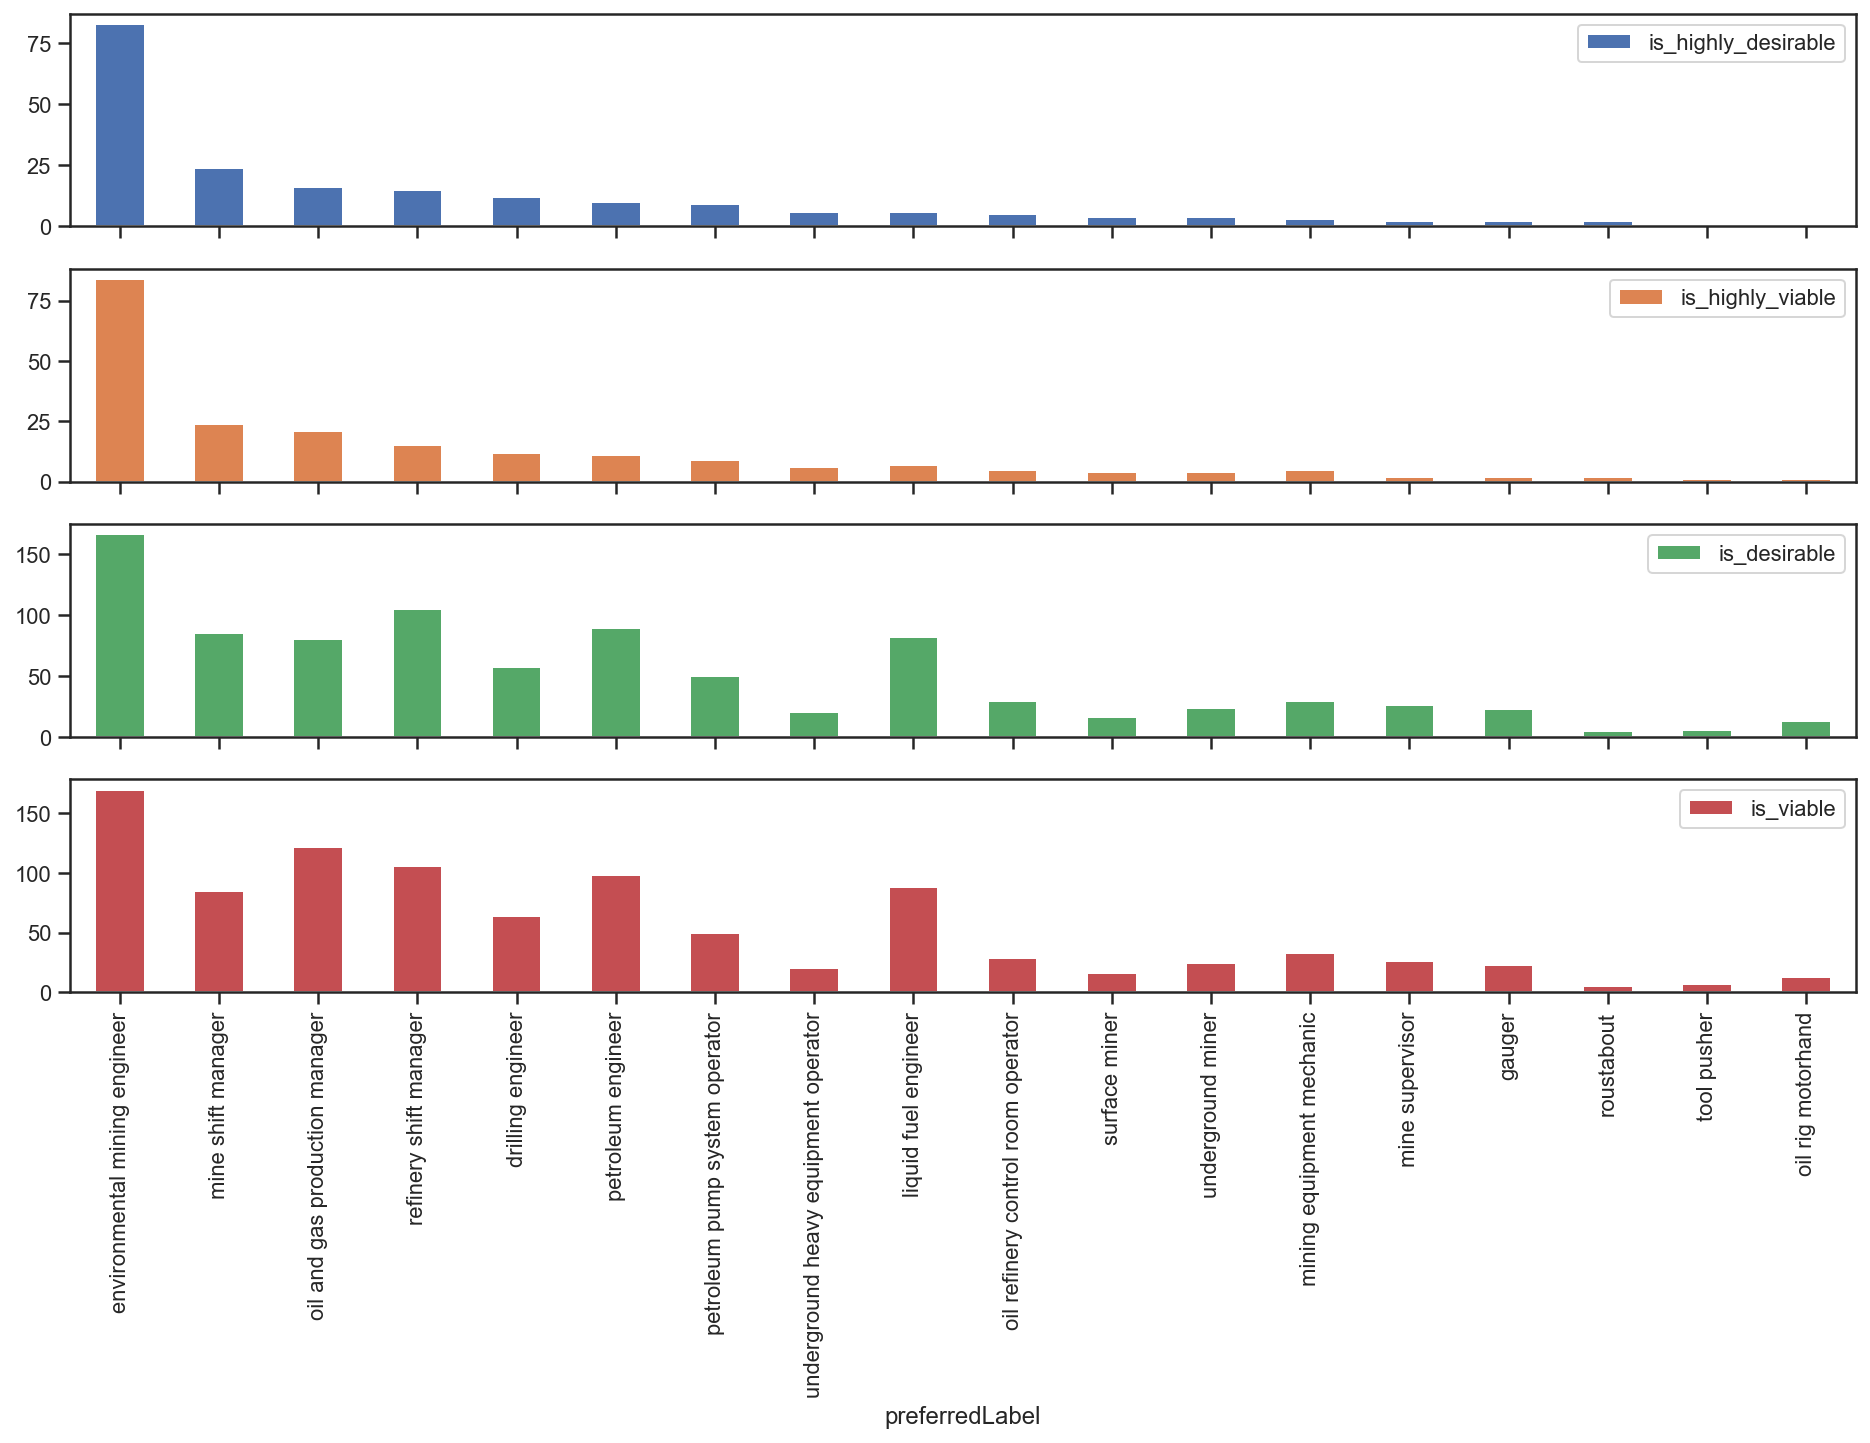

In [29]:
(df_transition_numbers_labelled
 .sort_values("is_highly_desirable", ascending=False)[['is_highly_desirable', 'is_highly_viable', 'is_desirable', 'is_viable', "preferredLabel"]]
 .plot.bar(
    x="preferredLabel",
    subplots=True,
    sharey=False,
    title=['', '', '', '']
 )
)

plt.savefig(
    os.path.join(figure_dir, "n_transitions_overview.png"),
    dpi=150,
    bbox_inches="tight"
)

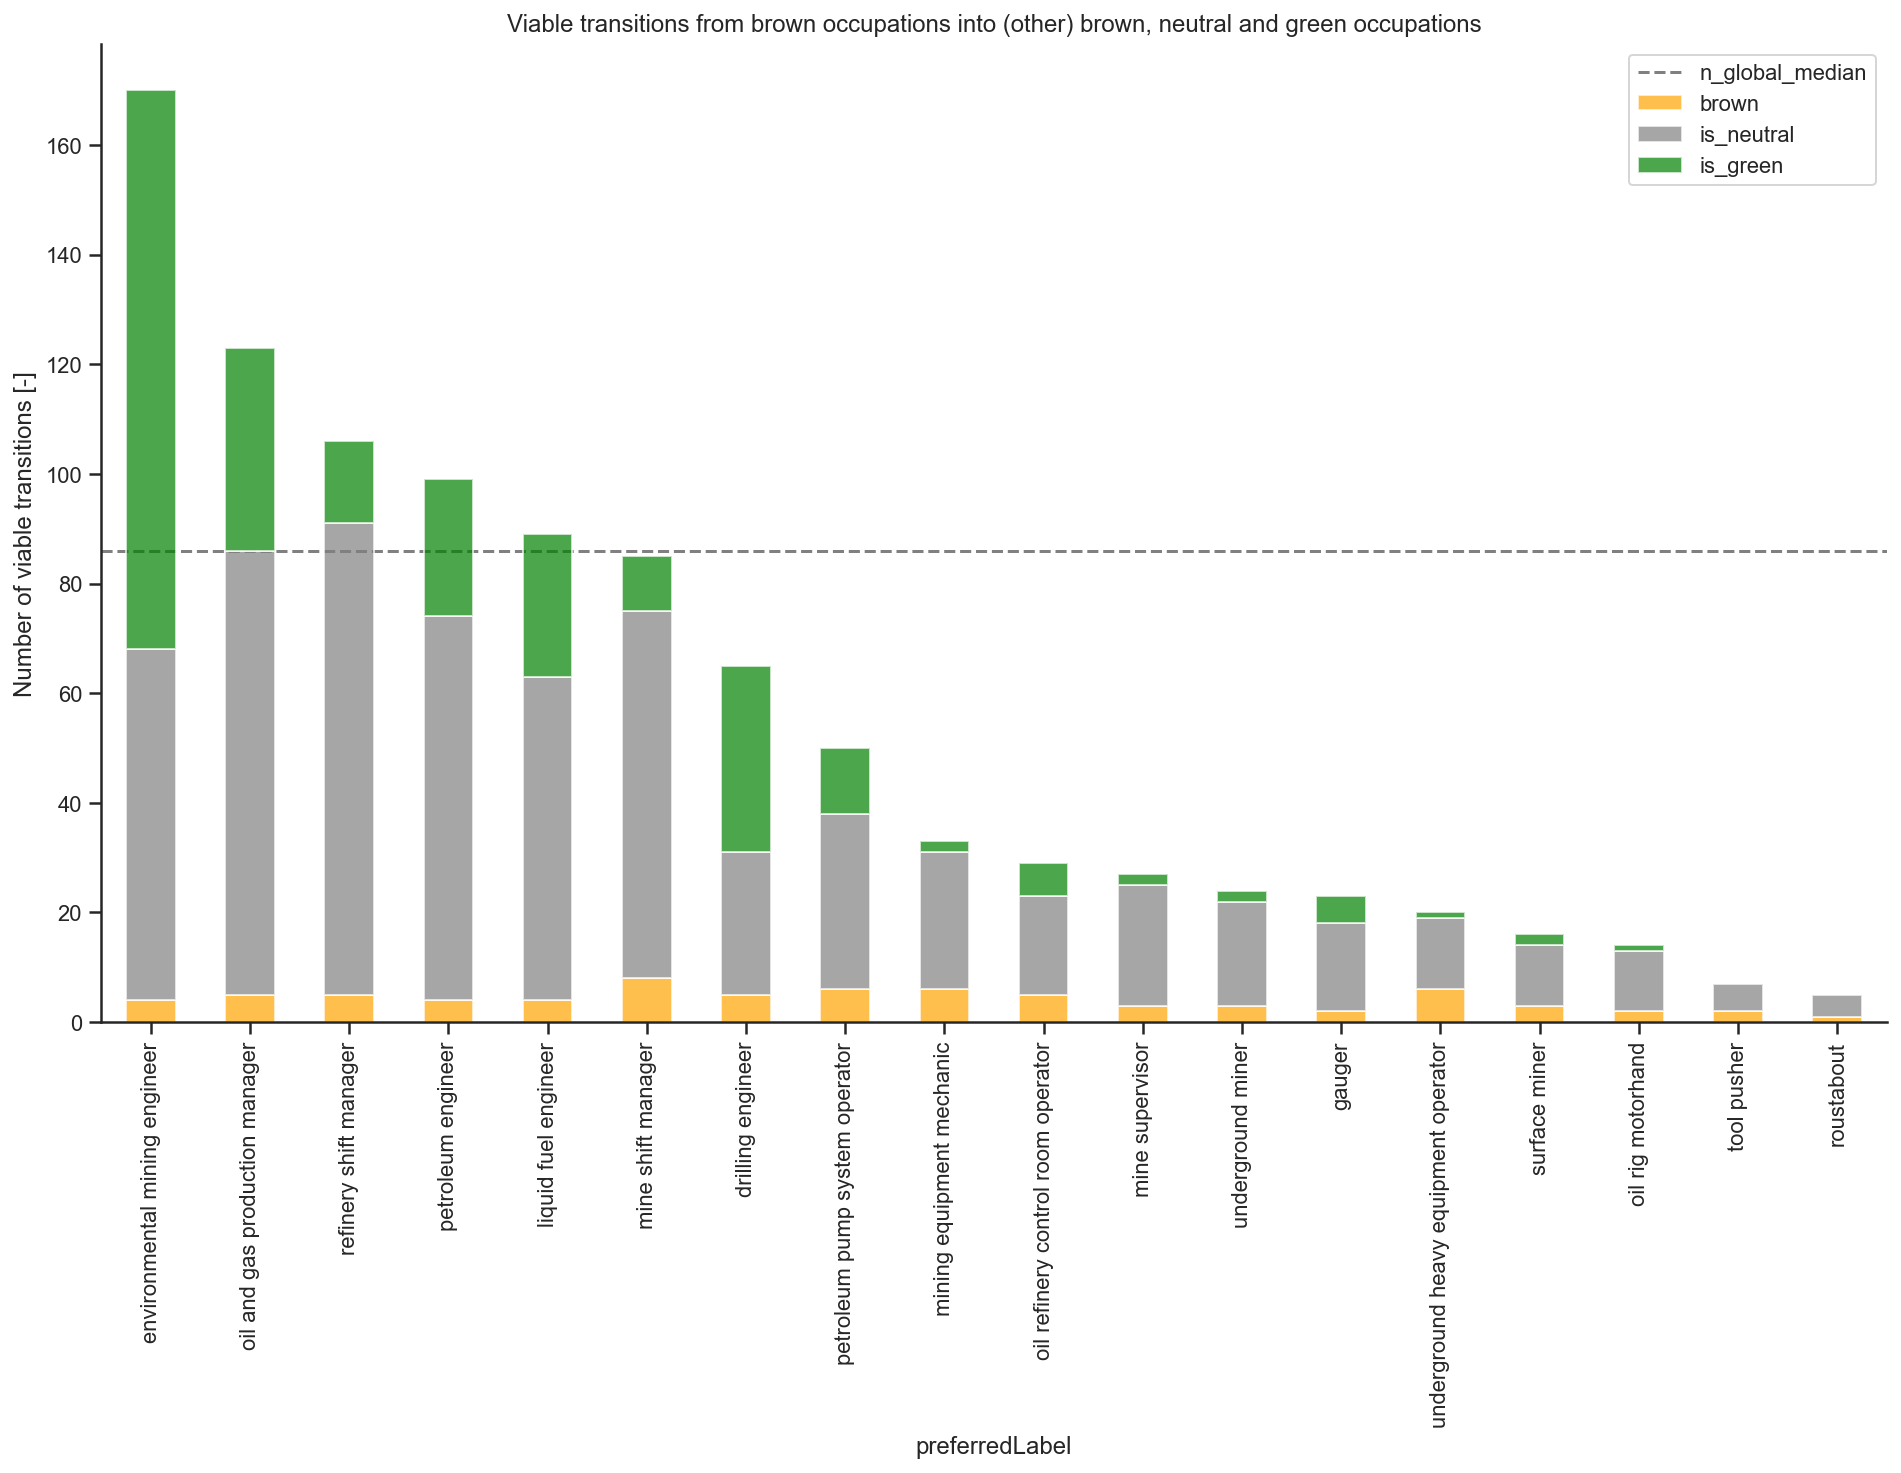

In [30]:
# viable transitions
ax = (df_transition_numbers_labelled
 .sort_values("is_viable", ascending=False)[["brown", "is_neutral", "is_green", "preferredLabel"]]
 .plot.bar(
    x="preferredLabel",
    sharey=False,
    stacked=True,
    title="Viable transitions from brown occupations into (other) brown, neutral and green occupations",
    ylabel="Number of viable transitions [-]",
    color=["orange", "grey", "green"],
    alpha=0.7
 )
)

# add median number of transitions
plt.axhline(
    y=df_transition_numbers_all_labelled.is_viable.median(),
    zorder=0,
    color="grey",
    linestyle="--",
    label="n_global_median"
)
plt.legend()
sns.despine()
plt.savefig(
    os.path.join(figure_dir, "n_viable_transitions.png"),
    dpi=150,
    bbox_inches="tight"
)

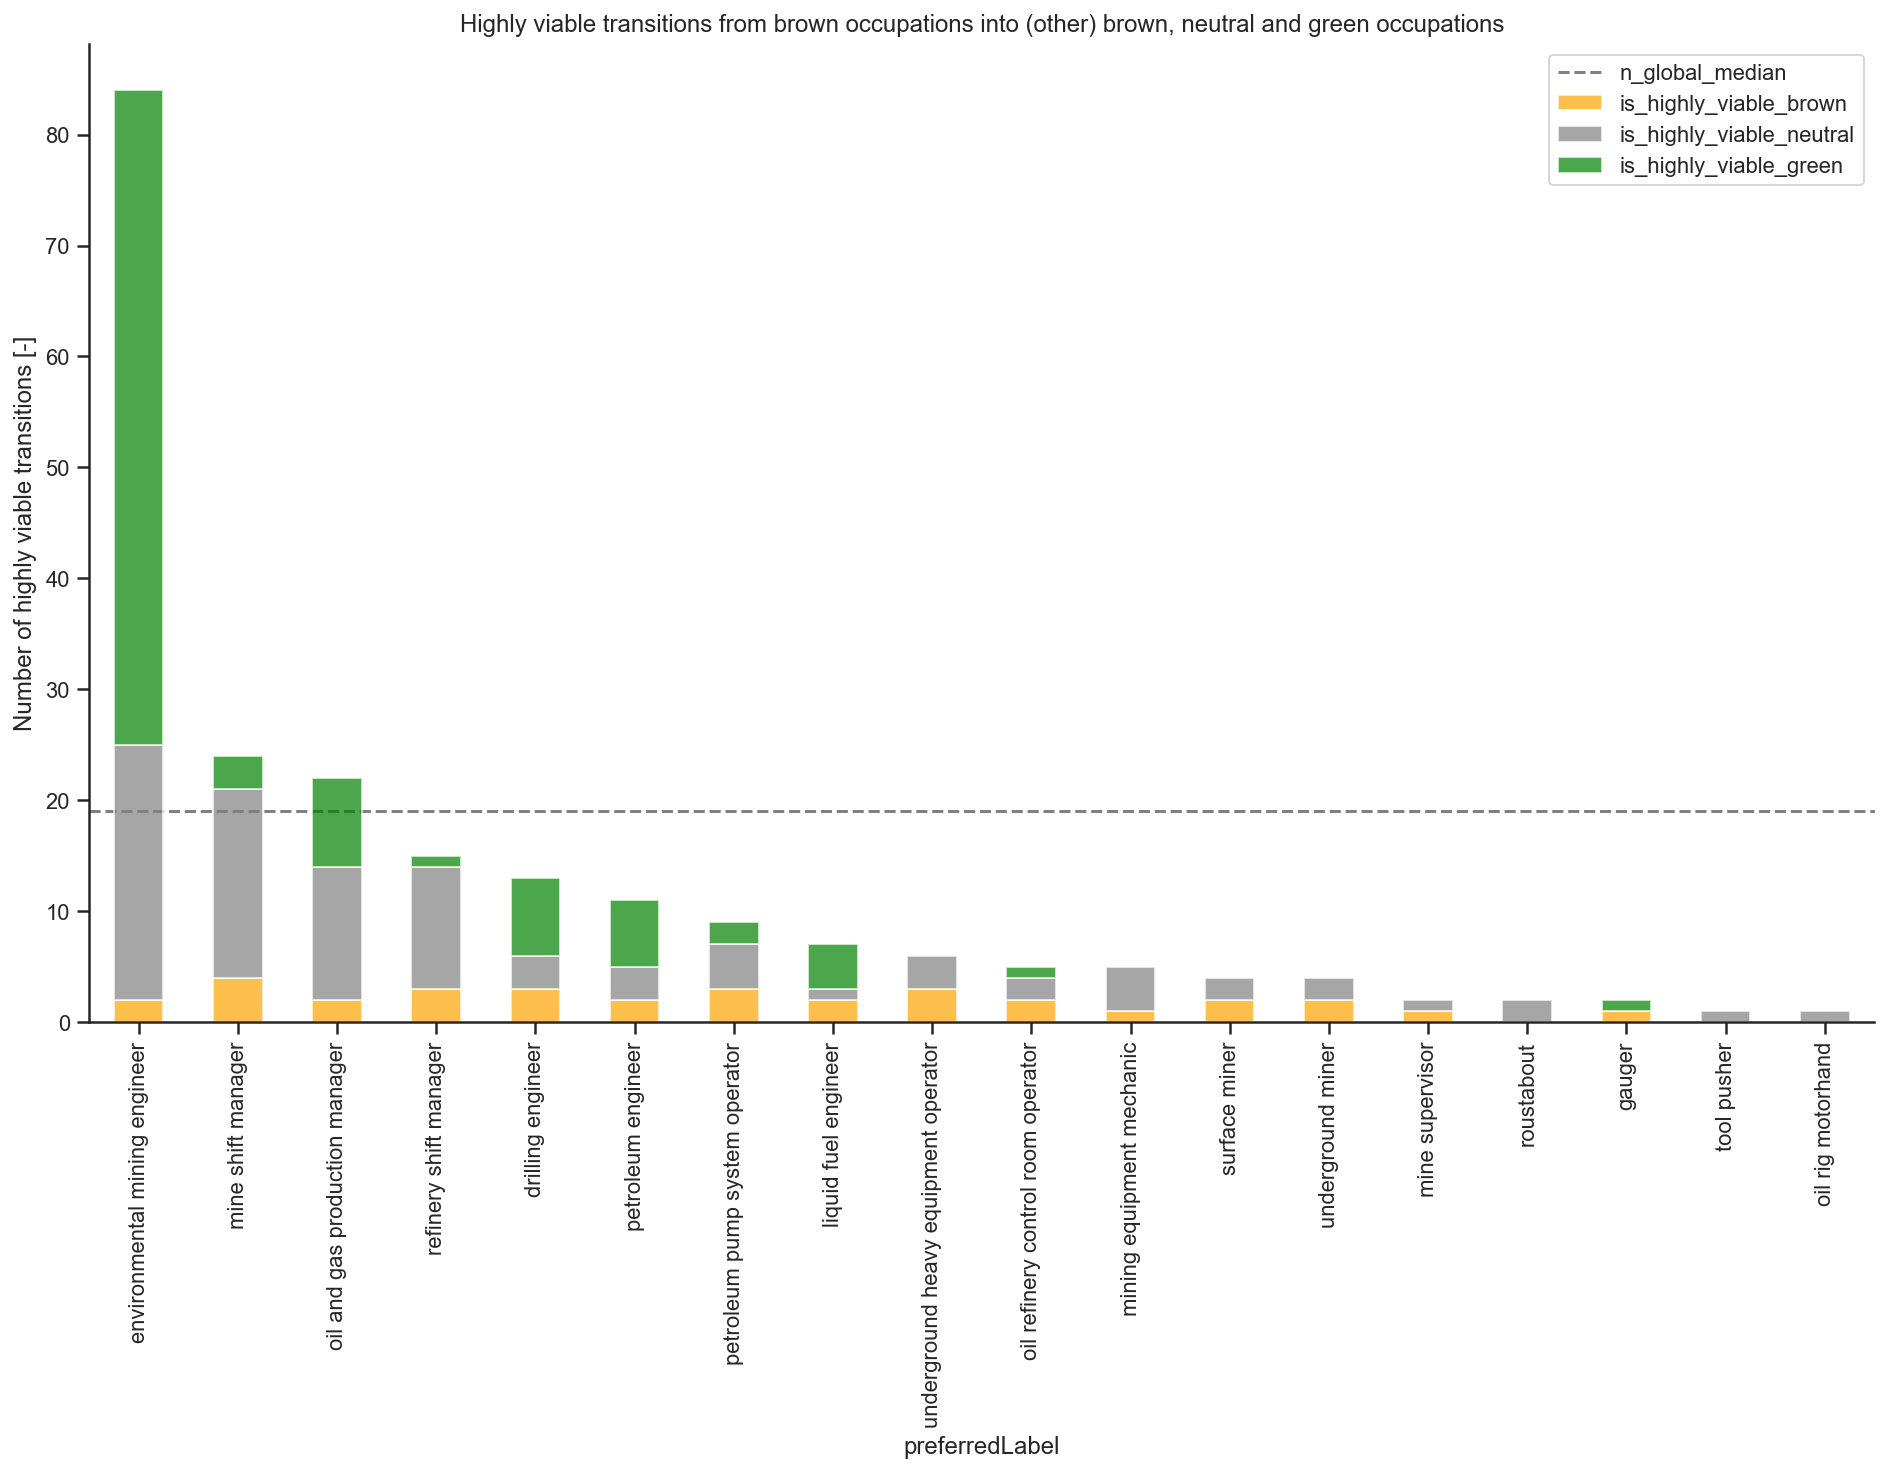

In [31]:
# highly viable transitions
(df_transition_numbers_labelled
 .sort_values("is_highly_viable", ascending=False)[["is_highly_viable_brown", "is_highly_viable_neutral", "is_highly_viable_green", "preferredLabel"]]
 .plot.bar(
    x="preferredLabel",
    sharey=False,
    stacked=True,
    title="Highly viable transitions from brown occupations into (other) brown, neutral and green occupations",
    ylabel="Number of highly viable transitions [-]",
    color=["orange", "grey", "green"],
    alpha=0.7
 )
)

# add median number of transitions
plt.axhline(
    y=df_transition_numbers_all_labelled.is_highly_viable.median(),
    zorder=0,
    color="grey",
    linestyle="--",
    label="n_global_median"
)
plt.legend()
sns.despine()
plt.savefig(
    os.path.join(figure_dir, "n_highly_viable_transitions.png"),
    dpi=150,
    bbox_inches="tight"
)

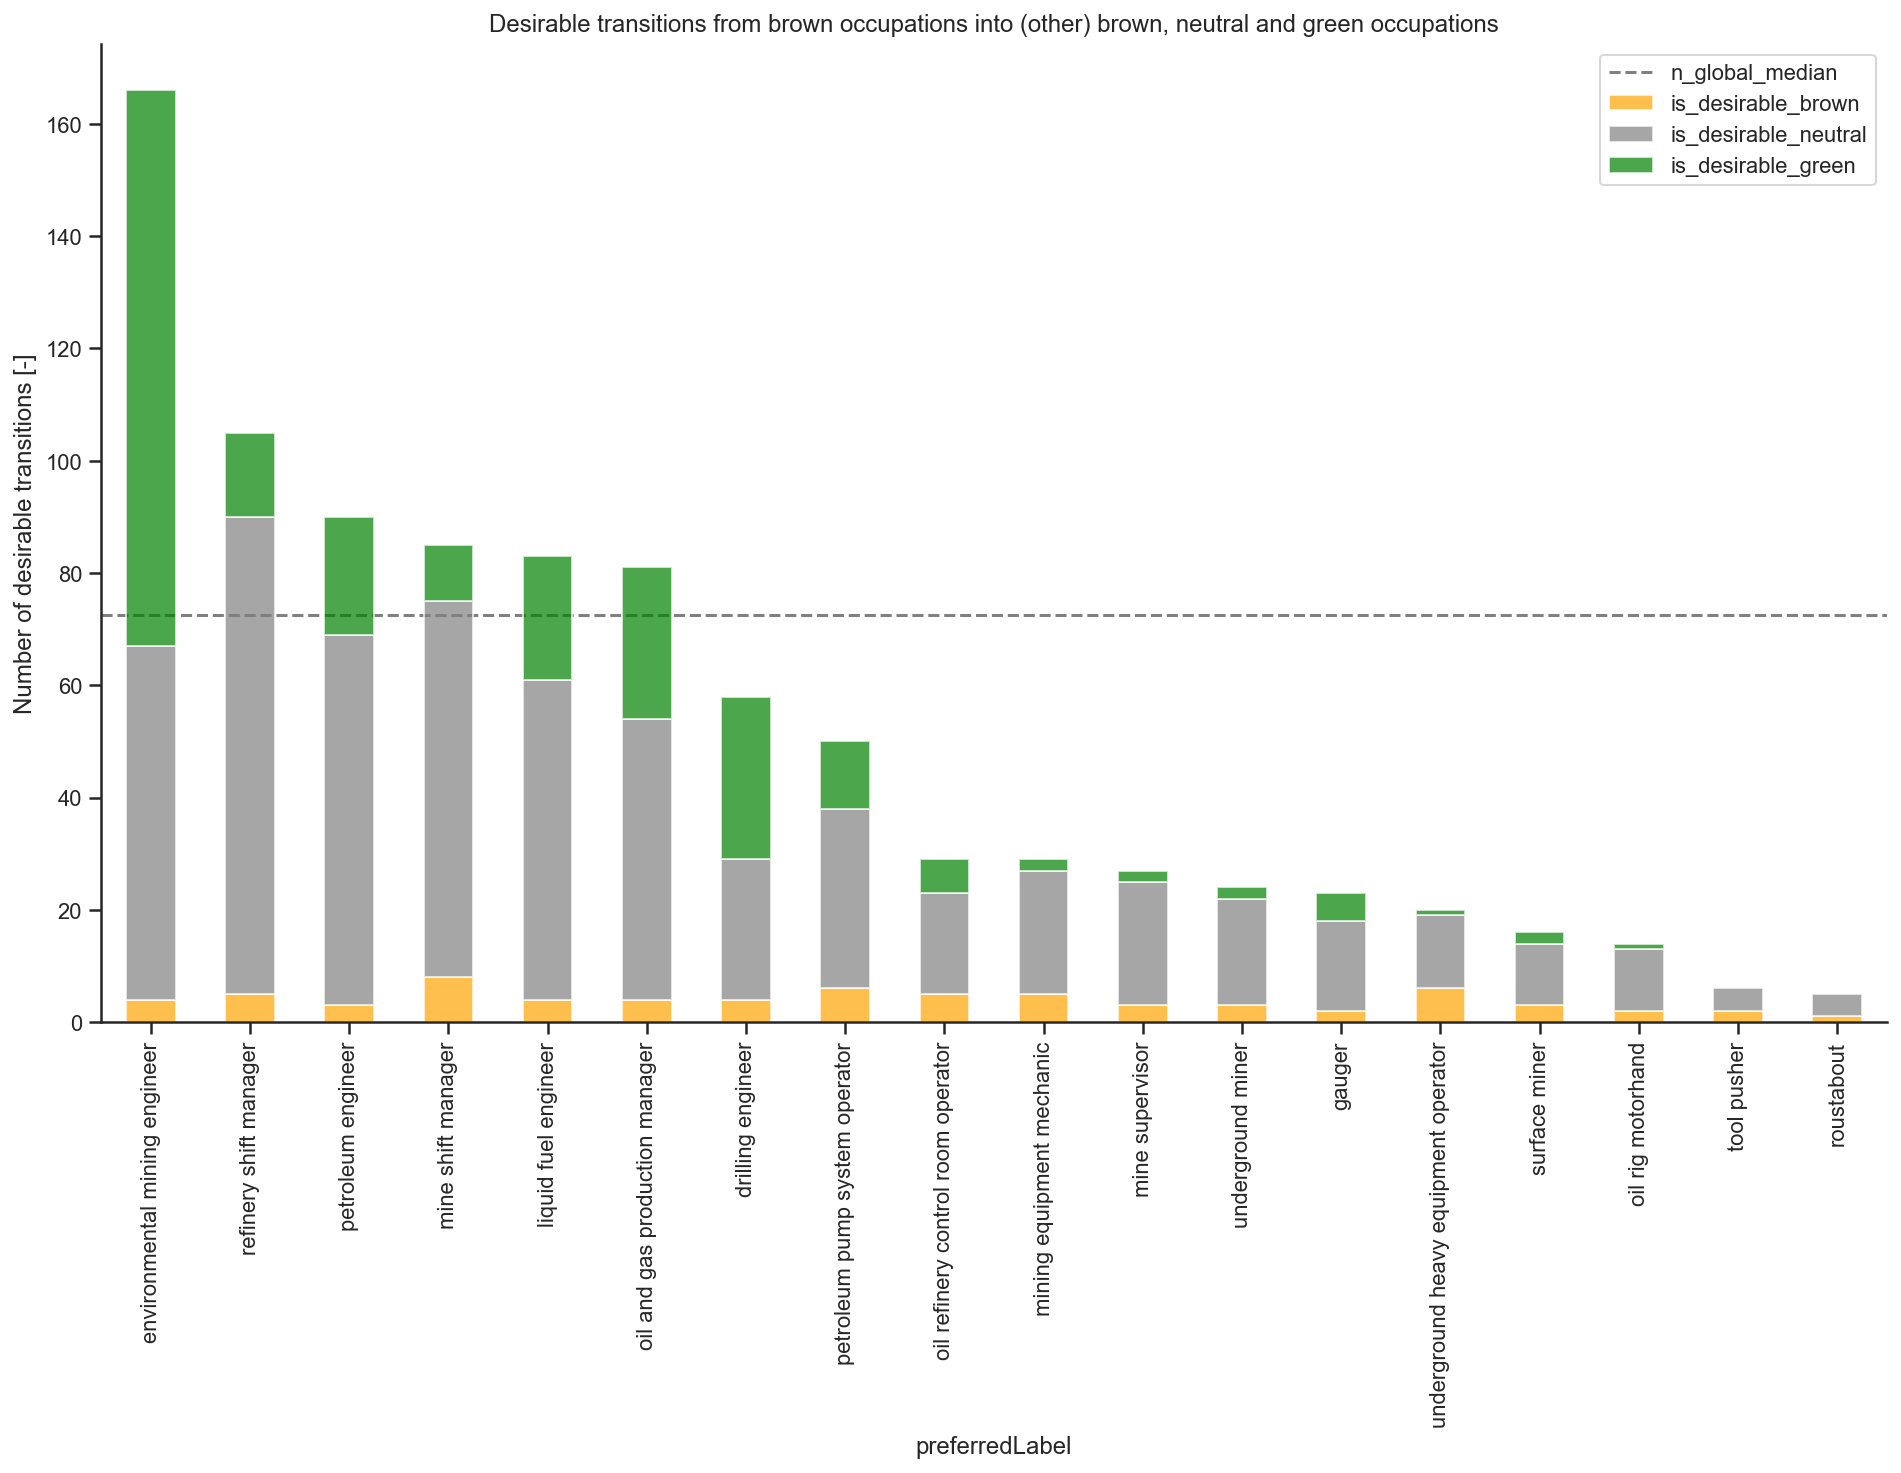

In [32]:
# desirable transitions
(df_transition_numbers_labelled
 .sort_values("is_desirable", ascending=False)[["is_desirable_brown", "is_desirable_neutral", "is_desirable_green", "preferredLabel"]]
 .plot.bar(
    x="preferredLabel",
    sharey=False,
    stacked=True,
    title="Desirable transitions from brown occupations into (other) brown, neutral and green occupations",
    ylabel="Number of desirable transitions [-]",
    color=["orange", "grey", "green"],
    alpha=0.7
 )
)

# add median number of transitions
plt.axhline(
    y=df_transition_numbers_all_labelled.is_desirable.median(),
    zorder=0,
    color="grey",
    linestyle="--",
    label="n_global_median"
)
plt.legend()
sns.despine()
plt.savefig(
    os.path.join(figure_dir, "n_desirable_transitions.png"),
    dpi=150,
    bbox_inches="tight"
)

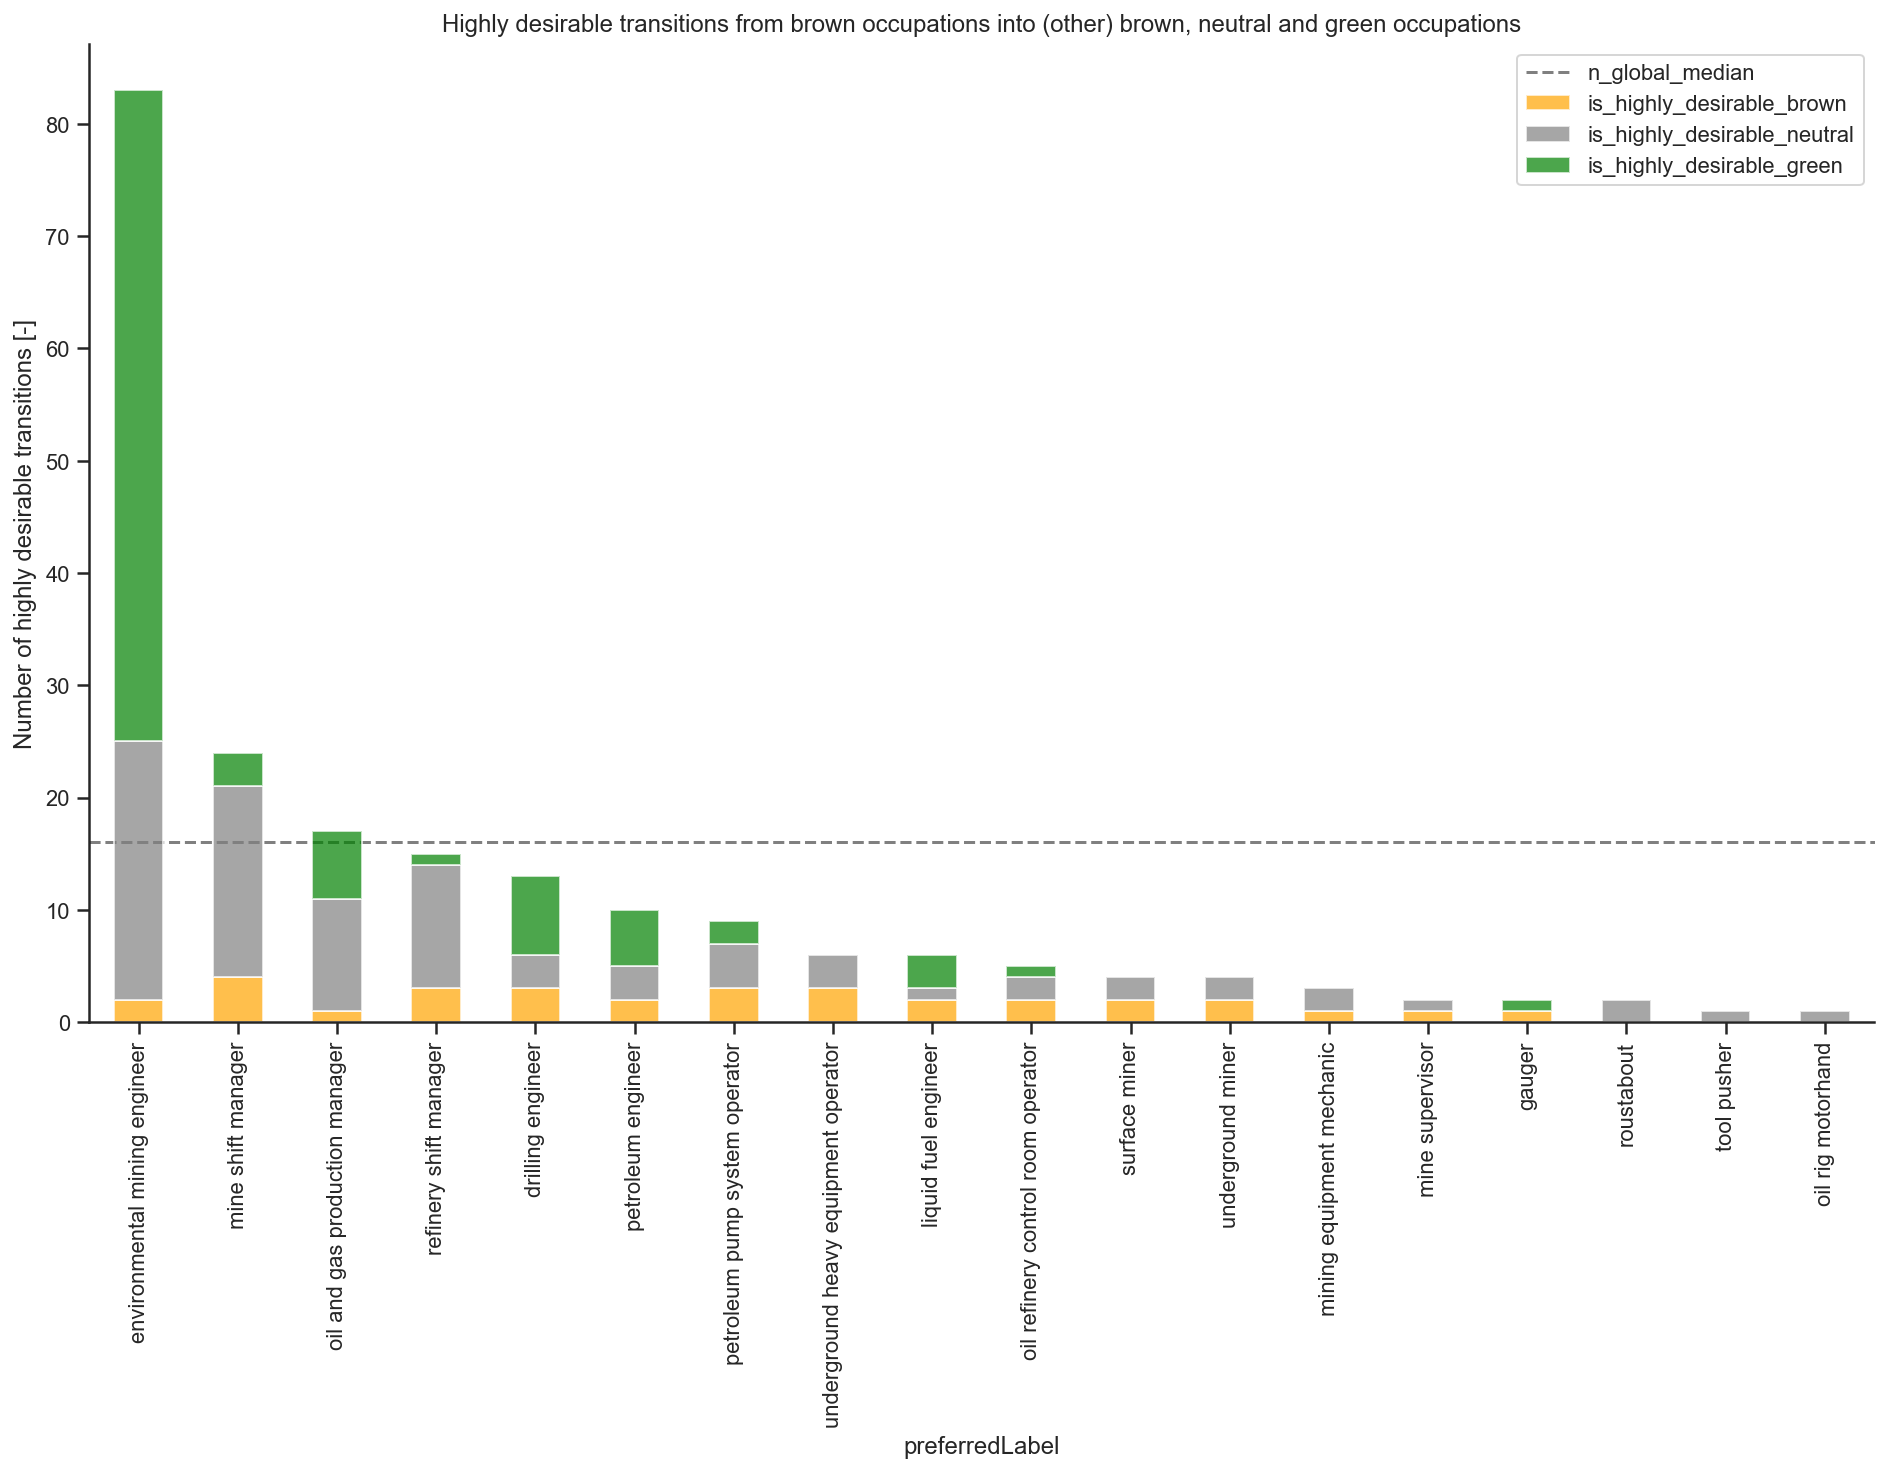

In [33]:
# highly desirable transitions
(df_transition_numbers_labelled
 .sort_values("is_highly_desirable", ascending=False)[["is_highly_desirable_brown", "is_highly_desirable_neutral", "is_highly_desirable_green", "preferredLabel"]]
 .plot.bar(
    x="preferredLabel",
    sharey=False,
    stacked=True,
    title="Highly desirable transitions from brown occupations into (other) brown, neutral and green occupations",
    ylabel="Number of highly desirable transitions [-]",
    color=["orange", "grey", "green"],
    alpha=0.7
 )
)

# add median number of transitions
plt.axhline(
    y=df_transition_numbers_all_labelled.is_highly_desirable.median(),
    zorder=0,
    color="grey",
    linestyle="--",
    label="n_global_median"
)
plt.legend()
sns.despine()

plt.savefig(
    os.path.join(figure_dir, "n_highly_desirable_transitions.png"),
    dpi=150,
    bbox_inches="tight"
)

## Analyse differences in transition numbers between groups (green, neutral, brown)


#### How do the transition numbers vary between green, neutral and brown occupations?

In [34]:
# ["brown", "neutral", "green"]
df_metadata_transitions2 = df_metadata_transitions.copy()

df_metadata_transitions2["occ_type"] = df_metadata_transitions2[["brown", "neutral", "green"]].idxmax(axis=1)

In [35]:
df_metadata_transitions2

,id,concept_uri,preferred_label,isco_level_4,onet_code,onet_occupation,isco_level_1,isco_level_2,isco_level_3,occupation_type,n_new_green_tasks,n_existing_green_tasks,n_non_green_tasks,greenness_vona_2018,greenness_vona_2018_v2,total_paid_hours,annual_earnings,employment_share,employment_count,job_zone,education_level,related_work_experience,on_the_job_training,skill_level_ilo,new_jobs_absorbing_ilo_2030_es,new_jobs_net_ilo_2030_es,jobs_lost_net_ilo_2030_es,jobs_lost_reallocated_ilo_2030_es,net_change_ilo_2030_es,new_jobs_absorbing_ilo_2030_ce,new_jobs_net_ilo_2030_ce,jobs_lost_net_ilo_2030_ce,jobs_lost_reallocated_ilo_2030_ce,net_change_ilo_2030_ce,mining_isco,mining_kw,brown,neutral,green,is_viable,is_highly_viable,is_desirable,is_highly_desirable,is_green,is_neutral,is_brown,is_highly_viable_brown,is_highly_viable_neutral,is_highly_viable_green,is_desirable_brown,is_desirable_neutral,is_desirable_green,is_highly_desirable_brown,is_highly_desirable_neutral,is_highly_desirable_green,occ_type
0,0,http://data.europa.eu/esco/occupation/00030d09...,technical director,2166,27-1011.00,art directors,2,21,216,Non Green,NaN,NaN,NaN,NaN,0.0000,36.670202,37555.308176,NaN,NaN,4.0,6.2477,8.0309,4.3843,H,500000.0,263000.0,253000.0,-500000.0,516000.0,1379000.0,1274000.0,-397000.0,-1379000.0,877000.0,False,False,False,True,False,19,0,18,0,2,17,0,0,0,0,0,16,2,0,0,0,neutral
1,1,http://data.europa.eu/esco/occupation/000e93a3...,metal drawing machine operator,8121,51-4021.00,"extruding and drawing machine setters, operato...",8,81,812,Non Green,NaN,NaN,NaN,NaN,0.0000,39.904110,22031.963636,0.000020,645.0,2.0,2.1163,2.4383,3.6486,M,339000.0,712000.0,-34000.0,-339000.0,678000.0,2913000.0,500.0,-5589000.0,-2913000.0,-5588500.0,False,False,False,True,False,174,123,174,123,11,163,0,0,119,4,0,163,11,0,119,4,neutral
2,2,http://data.europa.eu/esco/occupation/0019b951...,precision device inspector,7543,51-9061.00,"inspectors, testers, sorters, samplers, and we...",7,75,754,Green Enhanced Skills,2.0,0.0,30.0,0.066667,0.0625,38.709386,22430.367647,NaN,NaN,2.0,2.5397,4.8863,4.0288,M,48000.0,316000.0,500.0,-48000.0,316500.0,1315000.0,408000.0,-440000.0,-1315000.0,-32000.0,False,False,False,False,True,250,60,249,60,41,207,2,0,34,26,2,207,40,0,34,26,green
3,3,http://data.europa.eu/esco/occupation/0022f466...,air traffic safety technician,3155,17-3023.01,electronics engineering technicians,3,31,315,Non Green,NaN,NaN,NaN,NaN,0.0000,42.036716,32754.000000,0.000087,2797.0,3.0,4.3848,5.4808,4.0782,H,748000.0,528000.0,206000.0,-748000.0,734000.0,3042000.0,1225000.0,-965000.0,-3042000.0,260000.0,False,False,False,True,False,62,2,57,2,10,52,0,0,2,0,0,50,7,0,2,0,neutral
4,4,http://data.europa.eu/esco/occupation/002da35b...,hospitality revenue manager,2431,13-1161.00,market research analysts and marketing special...,2,24,243,Non Green,NaN,NaN,NaN,NaN,0.0000,36.354676,38839.816377,0.000648,20834.0,4.0,6.8261,6.3481,3.8265,H,218000.0,147000.0,-75000.0,-218000.0,72000.0,823000.0,837000.0,-53000.0,-823000.0,784000.0,False,False,False,True,False,217,13,200,12,72,144,1,0,11,2,1,131,68,0,10,2,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,2937,http://data.europa.eu/esco/occupation/ff656b3a...,demographer,2120,15-2041.00,statisticians,2,21,212,Non Green,NaN,NaN,NaN,NaN,0.0000,35.494487,36135.290249,0.000286,9184.0,5.0,8.3000,5.5000,4.6000,H,500000.0,263000.0,253000.0,-500000.0,516000.0,1379000.0,1274000.0,-397000.0,-1379000.0,877000.0,False,False,False,True,False,79,36,72,33,24,55,0,0,27,9,0,51,21,0,26,7,neutral
2938,2938,http://data.europa.eu/esco/occupation/ff8d4065...,sorter labourer,9612,51-9199.01,recycling and reclamation workers,9,96,961,New Green N&E,18.0,0.0,0.0,1.000000,1.0000,39.443972,21357.054545,0.000417,13414.0,2.0,3.1532,3.3559,2.8314,L,153000.0,305000.0,-17000.0,-153000.

In [36]:
df_metadata_transitions2_long = df_metadata_transitions2.melt(
    id_vars=["occ_type"],
    value_vars=["is_viable", "is_desirable", "is_highly_viable", "is_highly_desirable"],
    value_name="transitions",
    var_name="transition_category"
)

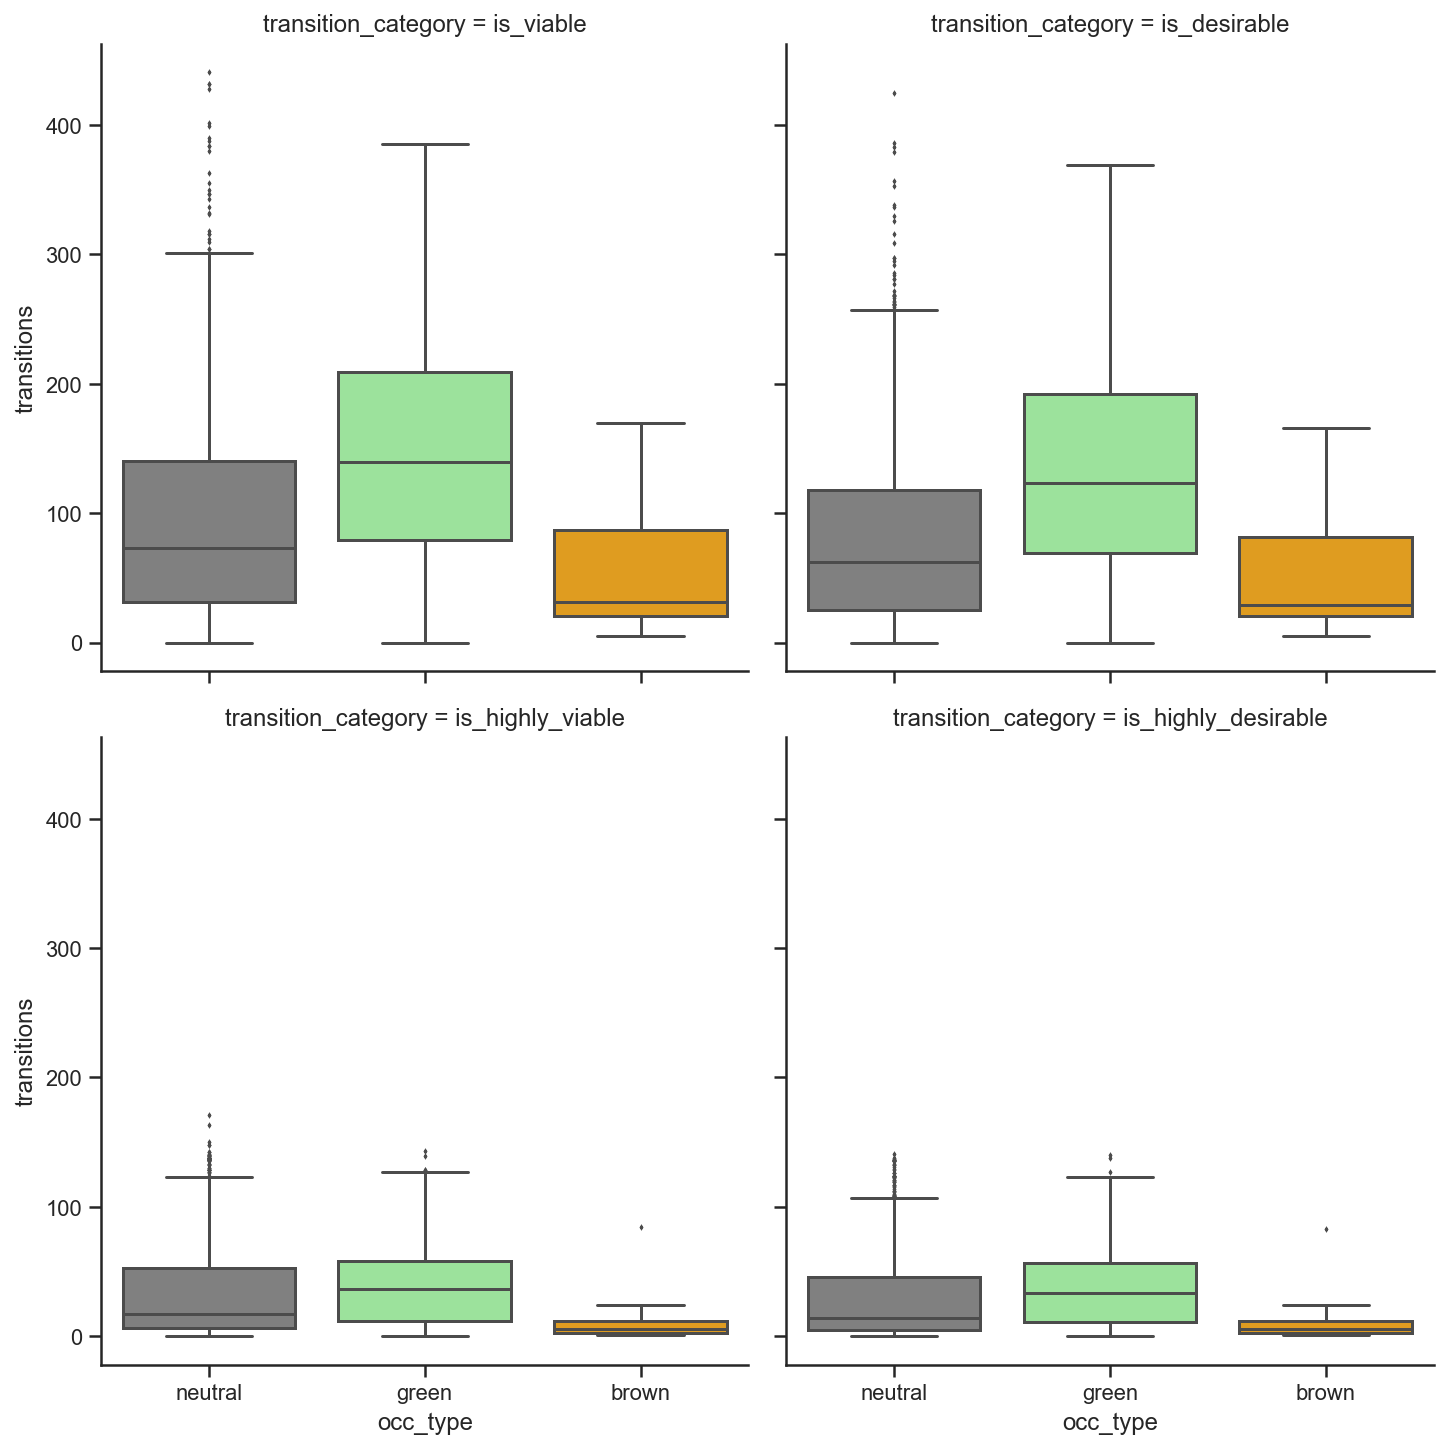

In [37]:
sns.catplot(
    y="transitions",
    x="occ_type",
    col="transition_category",
    col_wrap=2,
    palette=["grey", "lightgreen", "orange"],
    fliersize=1,
    kind="box",
    data=df_metadata_transitions2_long
)

plt.savefig(
    os.path.join(figure_dir, "n_transitions_by_occupation_type.png"),
    dpi=150,
    bbox_inches="tight"
)

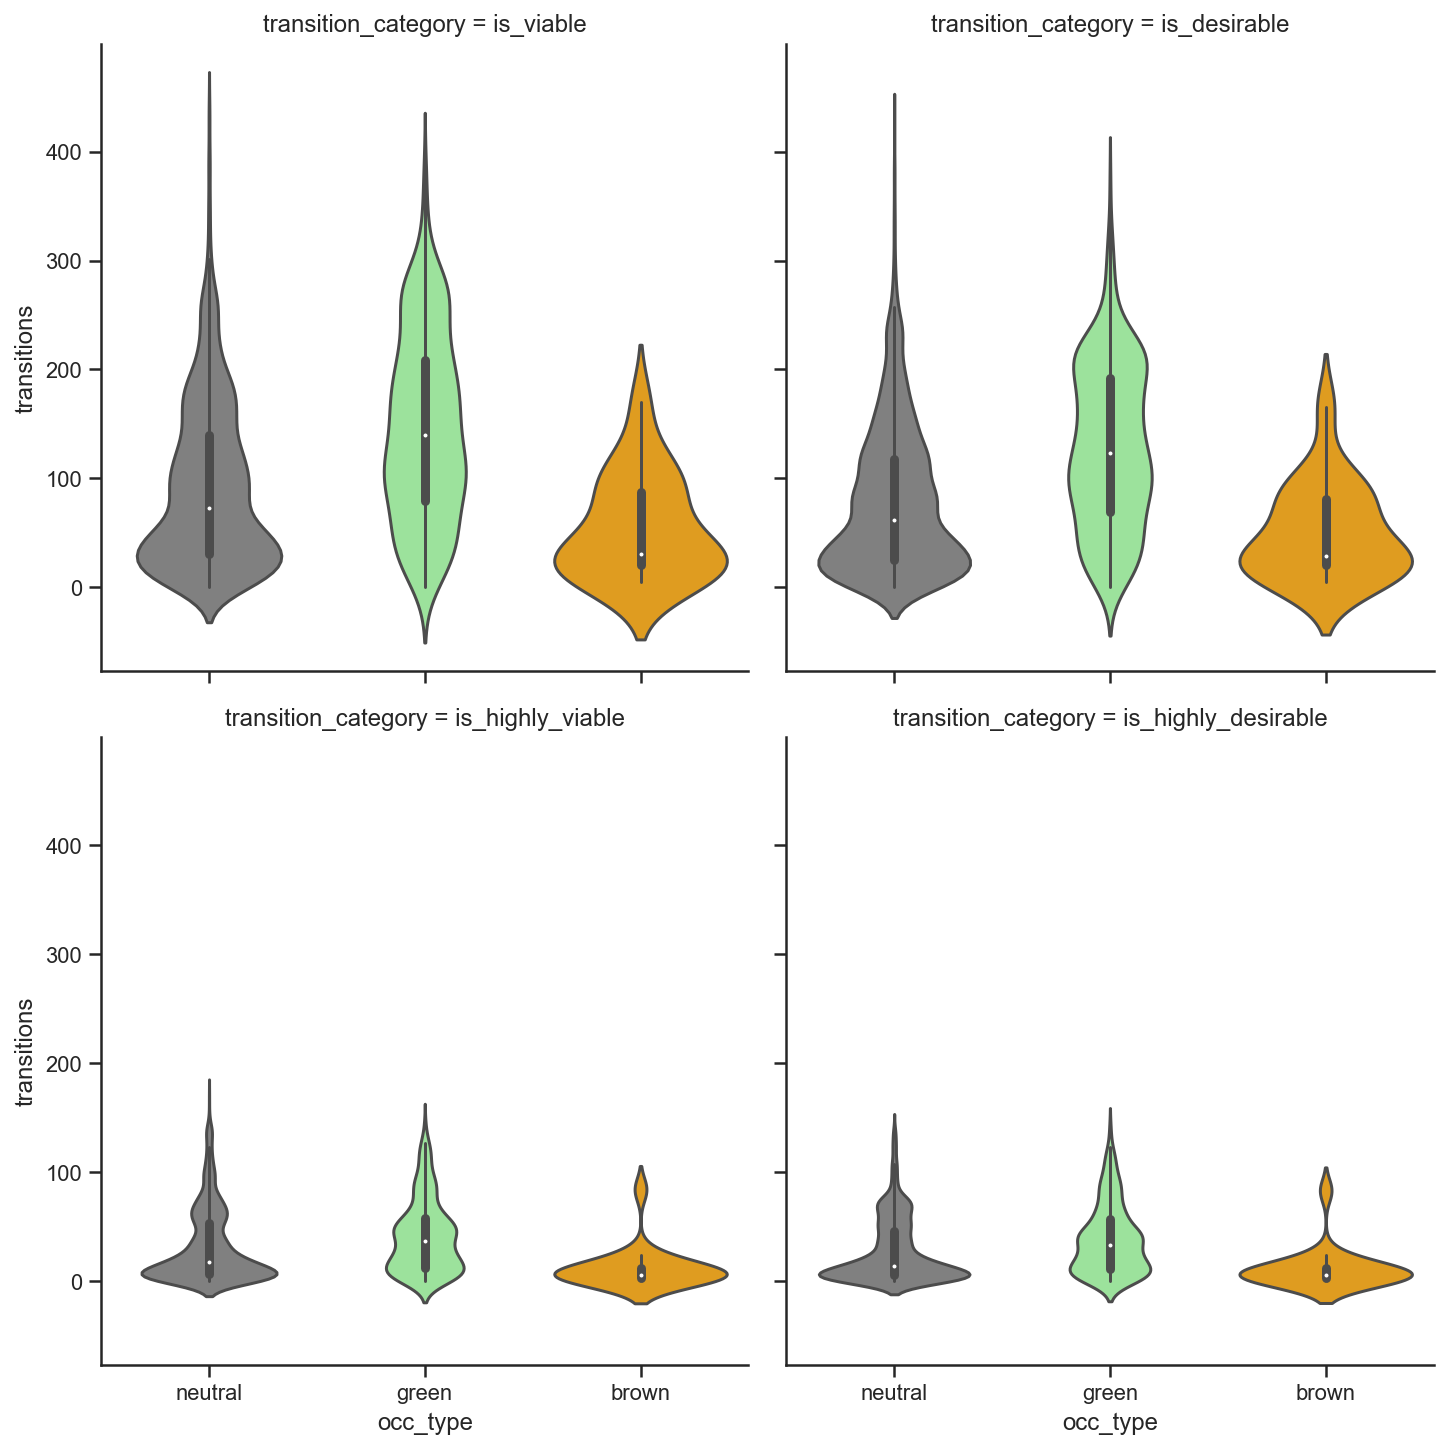

In [38]:
sns.catplot(
    y="transitions",
    x="occ_type",
    col="transition_category",
    col_wrap=2,
    palette=["grey", "lightgreen", "orange"],
    fliersize=1,
    kind="violin",
    data=df_metadata_transitions2_long
)

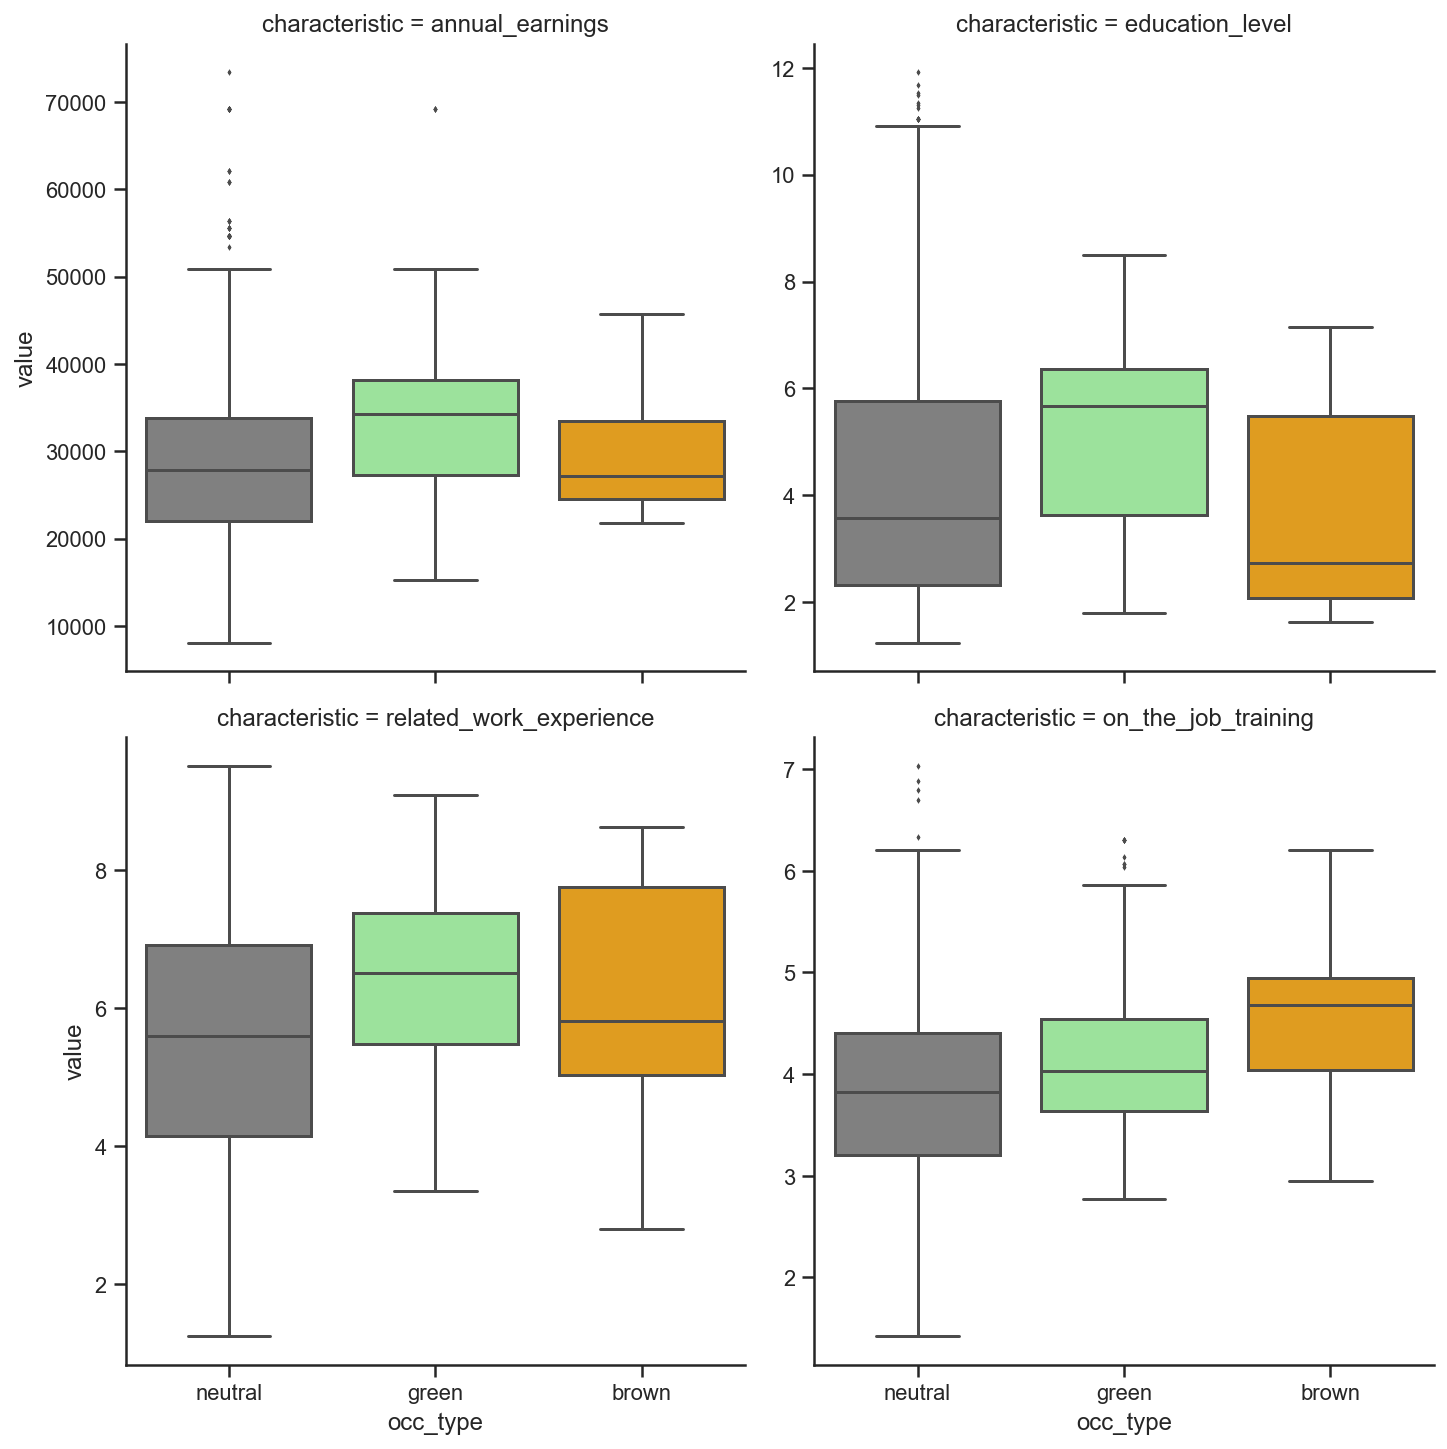

In [39]:
df_metadata_transitions3_long = df_metadata_transitions2.melt(
    id_vars=["occ_type"],
    value_vars=["annual_earnings", "education_level", "related_work_experience", "on_the_job_training"],
    value_name="value",
    var_name="characteristic"
)

sns.catplot(
    y="value",
    x="occ_type",
    col="characteristic",
    col_wrap=2,
    palette=["grey", "lightgreen", "orange"],
    fliersize=1,
    kind="box",
    sharey=False,
    data=df_metadata_transitions3_long
)

plt.savefig(
    os.path.join(figure_dir, "educ_pay_by_occupation_type.png"),
    dpi=150,
    bbox_inches="tight"
)

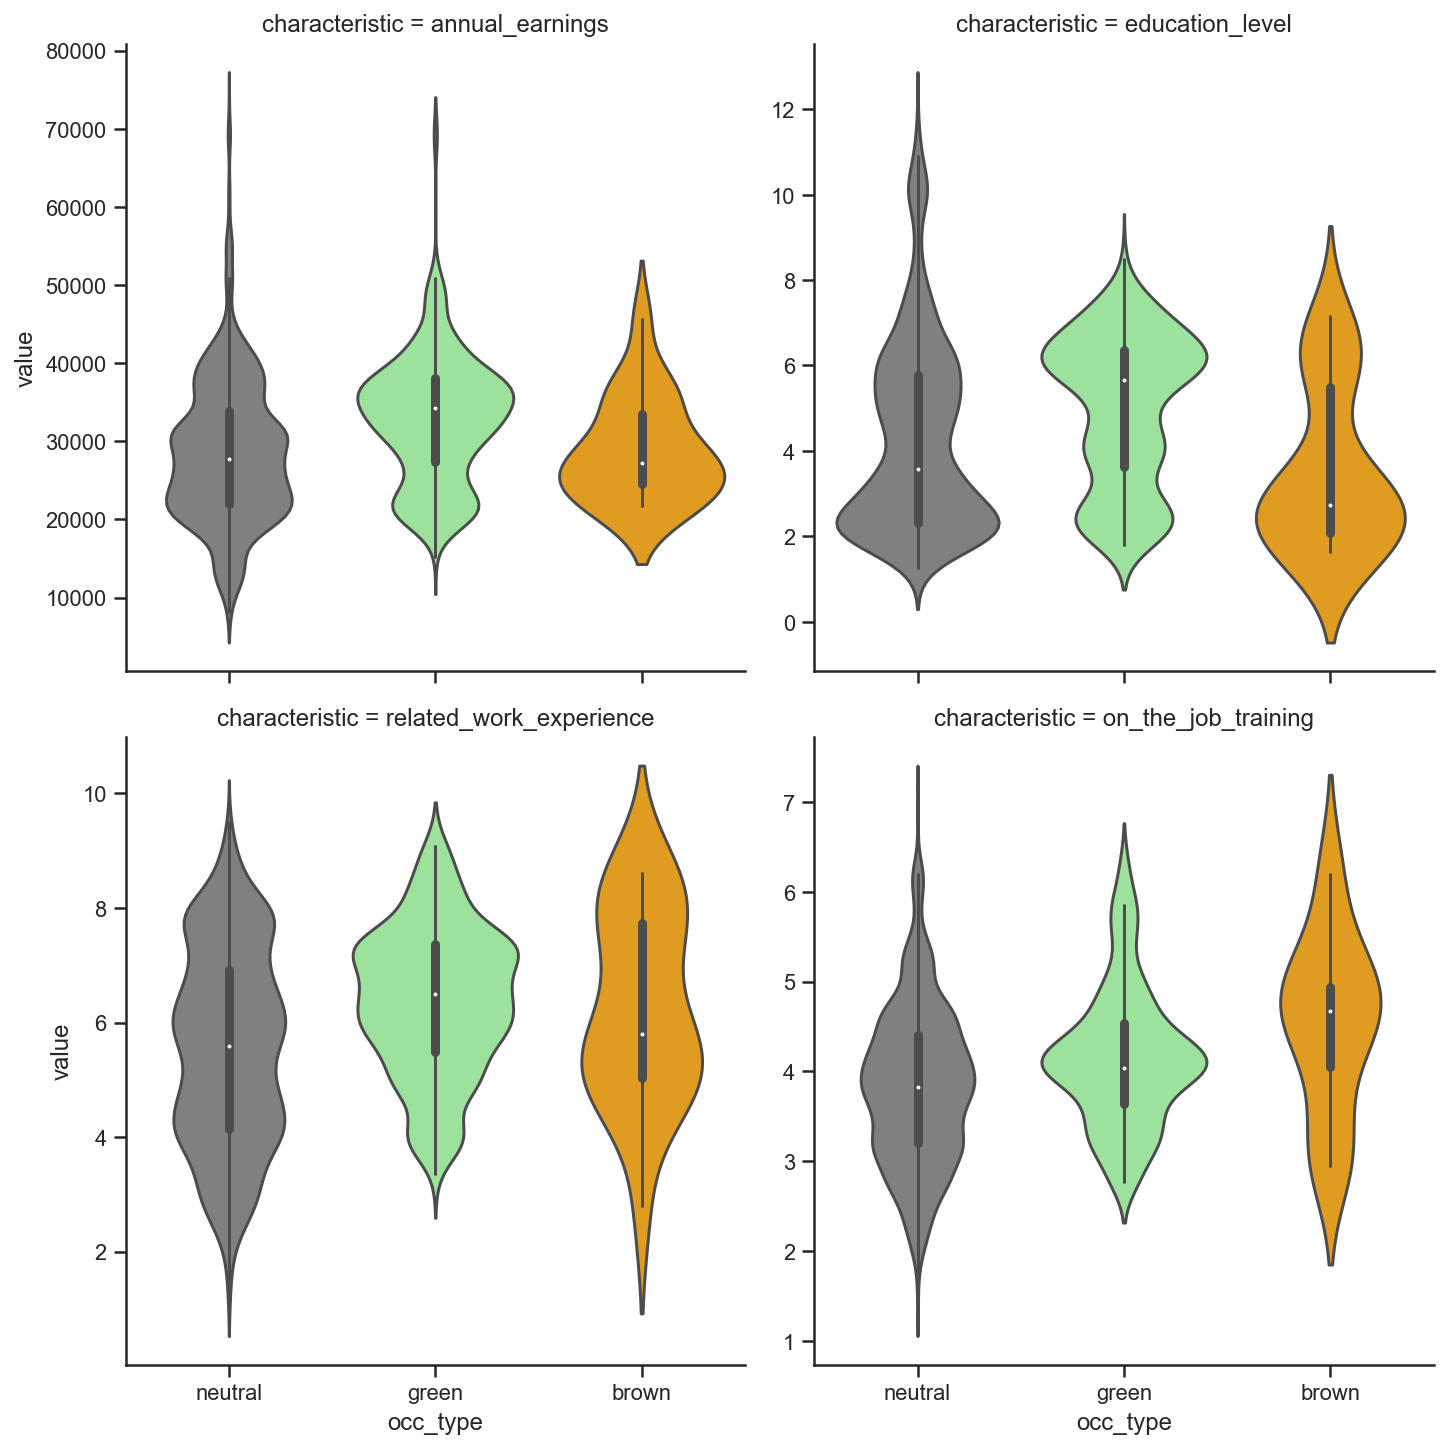

In [40]:
sns.catplot(
    y="value",
    x="occ_type",
    col="characteristic",
    col_wrap=2,
    palette=["grey", "lightgreen", "orange"],
    fliersize=1,
    kind="violin",
    sharey=False,
    data=df_metadata_transitions3_long
)

In [41]:
# t-tests for diff in means
from scipy import stats

stats.ttest_ind(
    df_metadata_transitions2.is_desirable_brown,
    df_metadata_transitions2.is_desirable_green
)

Ttest_indResult(statistic=-39.76150200089598, pvalue=1.9609204862731055e-306)

In [42]:
stats.ttest_ind(
    df_metadata_transitions2.is_desirable_brown,
    df_metadata_transitions2.is_desirable_neutral
)

Ttest_indResult(statistic=-67.1896758795253, pvalue=0.0)

In [43]:
stats.ttest_ind(
    df_metadata_transitions2.is_desirable_green,
    df_metadata_transitions2.is_desirable_neutral
)


Ttest_indResult(statistic=-42.54010261907161, pvalue=0.0)